In [2]:
from dolphindb import session
import numpy as np
import pandas as pd
import json
from datetime import datetime, timedelta
import sys
import os
import traceback
from scipy.interpolate import CubicSpline

In [3]:
def query_dolphindb():
    try:
        s = session()
        s.connect("46.202.149.154", 8848, "admin", "123456")
        s.run('t = loadTable("dfs://yfs", "stockdata_1d")')
        ddb_data = s.run('select Datetime, Symbol, AdjClose from t where Datetime > 2021.01.01T03:00:00')
        return pd.DataFrame(ddb_data)
    except Exception as e:
        print(f"Error querying DolphinDB: {str(e)}", file=sys.stderr)
        return None

def calculate_returns(data, tickers, period, iterations, time_steps):
    today = datetime.now()
    start_date = (today - timedelta(days=period * 30)).strftime('%Y-%m-%d')
    end_date = today.strftime('%Y-%m-%d')
    
    df = data[data['Symbol'].isin(tickers)]
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)]
    df = df.pivot(index='Datetime', columns='Symbol', values='AdjClose')

    results = {}
    for ticker in tickers:
        asset_df = df[[ticker]].copy()
        asset_df.columns = ['price']
        
        asset_df['simple_return'] = asset_df['price'].pct_change()
        asset_df['log_return'] = np.log(1 + asset_df['simple_return'])
        asset_df.dropna(subset=['simple_return', 'log_return'], inplace=True)

        cdf_values = calculate_cdf_values(asset_df)
        
        mc_results = mc_bootstrap(cdf_values['S0'], cdf_values['interpolated_cdf_values'], cdf_values['sorted_values'], time_steps=time_steps, iterations=iterations)
        
        results[ticker] = {
            'returns': asset_df[['simple_return', 'log_return']].to_dict(orient='list'),
            'cdf_values': cdf_values,
            'monte_carlo': mc_results
        }

    return results

def calculate_cdf_values(asset_df):
    sorted_values = np.unique(np.sort(asset_df['log_return']))
    ecdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    cs = CubicSpline(sorted_values, ecdf)
    interpolated_cdf_values = cs(sorted_values)

    min_length = min(len(sorted_values), len(interpolated_cdf_values))
    sorted_values = sorted_values[:min_length]
    interpolated_cdf_values = interpolated_cdf_values[:min_length]
    sf_interpolated = 1 - interpolated_cdf_values
    S0 = asset_df['price'].iloc[-1]
    mu = np.median(asset_df['log_return'])

    return {
        'S0': float(S0),
        'sf_interpolated': sf_interpolated.tolist(),
        'sorted_values': sorted_values.tolist(),
        'interpolated_cdf_values': interpolated_cdf_values.tolist(),
        'mu': float(mu)
    }

def mc_bootstrap(S0, cdf_empirical_interpolated, sorted_values, time_steps, iterations):
    def _run_simulation(time_steps, iterations):                     
        U = np.random.rand(time_steps, iterations)
        Z = np.interp(U, cdf_empirical_interpolated, sorted_values)
        factor = np.exp(Z)
        paths = S0 * np.cumprod(factor, axis=0)
        arrival_values = paths[-1]
        return arrival_values
    
    arrival_values = _run_simulation(time_steps, iterations)
    
    return {
        'mean': float(np.mean(arrival_values)),
        'median': float(np.median(arrival_values)),
        'std': float(np.std(arrival_values)),
        'min': float(np.min(arrival_values)),
        'max': float(np.max(arrival_values)),
        'percentiles': {
            '1%': float(np.percentile(arrival_values, 1)),
            '5%': float(np.percentile(arrival_values, 5)),
            '25%': float(np.percentile(arrival_values, 25)),
            '75%': float(np.percentile(arrival_values, 75)),
            '95%': float(np.percentile(arrival_values, 95)),
            '99%': float(np.percentile(arrival_values, 99))
        },
        'all_arrivals': arrival_values.tolist()  # Convert numpy array to list for JSON serialization
    }

def run_bootstrap(stocks, period, iterations, time_steps):
    try:
        ddb_data = query_dolphindb()
        if ddb_data is None:
            raise Exception("Failed to query DolphinDB")

        results = calculate_returns(ddb_data, stocks.split(','), period, iterations, time_steps)
        return results

    except Exception as e:
        print(f"Error in bootstrap execution: {str(e)}", file=sys.stderr)
        print(traceback.format_exc(), file=sys.stderr)
        raise

# Monte Carlo Bootstrap Examples with PETR4

This notebook demonstrates how to run the Monte Carlo bootstrap simulation and visualize the results using PETR4 as an example.

In [22]:
# Run the bootstrap simulation for PETR4
# Set parameters
ticker = "PETR4"
period = 24  # months
iterations = 5000 # number of simulation paths
time_steps = 21  # trading days in a year

# Run simulation
results = run_bootstrap(ticker, period, iterations, time_steps)

# Display basic statistics of the Monte Carlo simulation
print(f"Monte Carlo results for {ticker} over {period} months:")
mc_stats = results[ticker]['monte_carlo']
for key in ['mean', 'median', 'std', 'min', 'max']:
    print(f"{key}: {mc_stats[key]:.2f}")

print("\nPercentiles:")
for key, value in mc_stats['percentiles'].items():
    print(f"{key}: {value:.2f}")

Monte Carlo results for PETR4 over 24 months:
mean: 32.59
median: 32.60
std: 2.53
min: 23.37
max: 42.15

Percentiles:
1%: 26.76
5%: 28.34
25%: 30.96
75%: 34.30
95%: 36.73
99%: 38.48


C:\Users\ojuar\AppData\Local\Temp\ipykernel_8364\1554635376.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Datetime'] = pd.to_datetime(df['Datetime'])


In [23]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set the style
plt.style.use('fivethirtyeight')
sns.set_palette('colorblind')

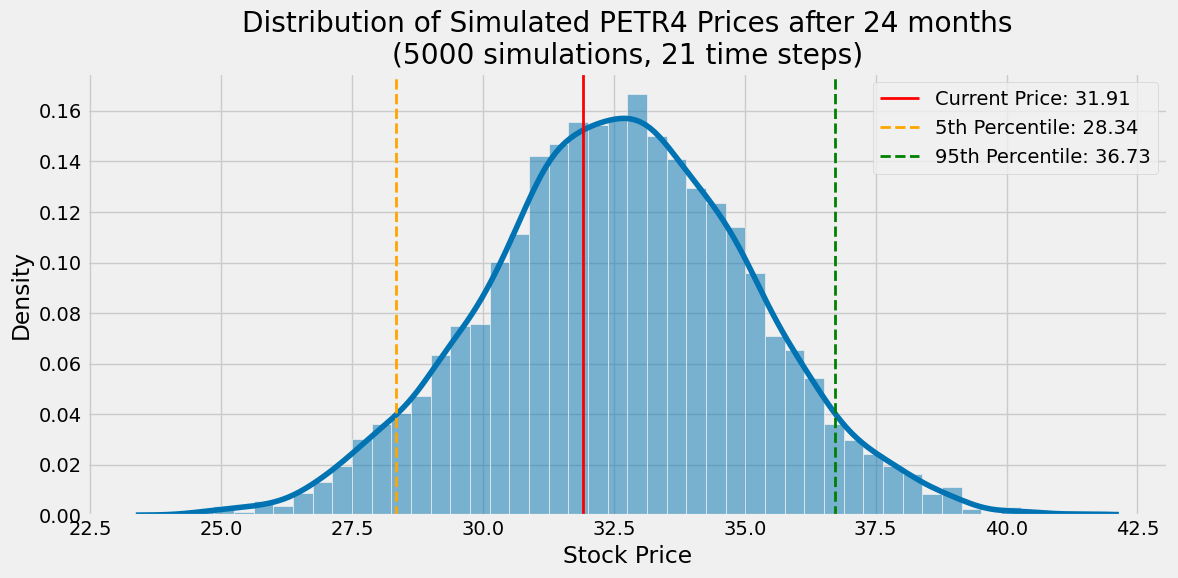

In [24]:
# Plot histogram of arrival values (final prices)
plt.figure(figsize=(12, 6))

arrival_values = results[ticker]['monte_carlo']['all_arrivals']
current_price = results[ticker]['cdf_values']['S0']

# Create histogram
sns.histplot(arrival_values, kde=True, stat='density', bins=50)

# Add vertical lines for current price and key percentiles
plt.axvline(current_price, color='red', linestyle='-', linewidth=2, label=f'Current Price: {current_price:.2f}')
plt.axvline(mc_stats['percentiles']['5%'], color='orange', linestyle='--', linewidth=2, label=f'5th Percentile: {mc_stats["percentiles"]["5%"]:.2f}')
plt.axvline(mc_stats['percentiles']['95%'], color='green', linestyle='--', linewidth=2, label=f'95th Percentile: {mc_stats["percentiles"]["95%"]:.2f}')

plt.title(f'Distribution of Simulated {ticker} Prices after {period} months\n({iterations} simulations, {time_steps} time steps)')
plt.xlabel('Stock Price')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\ojuar\AppData\Local\Temp\ipykernel_8364\2914818633.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Datetime'] = pd.to_datetime(df['Datetime'])


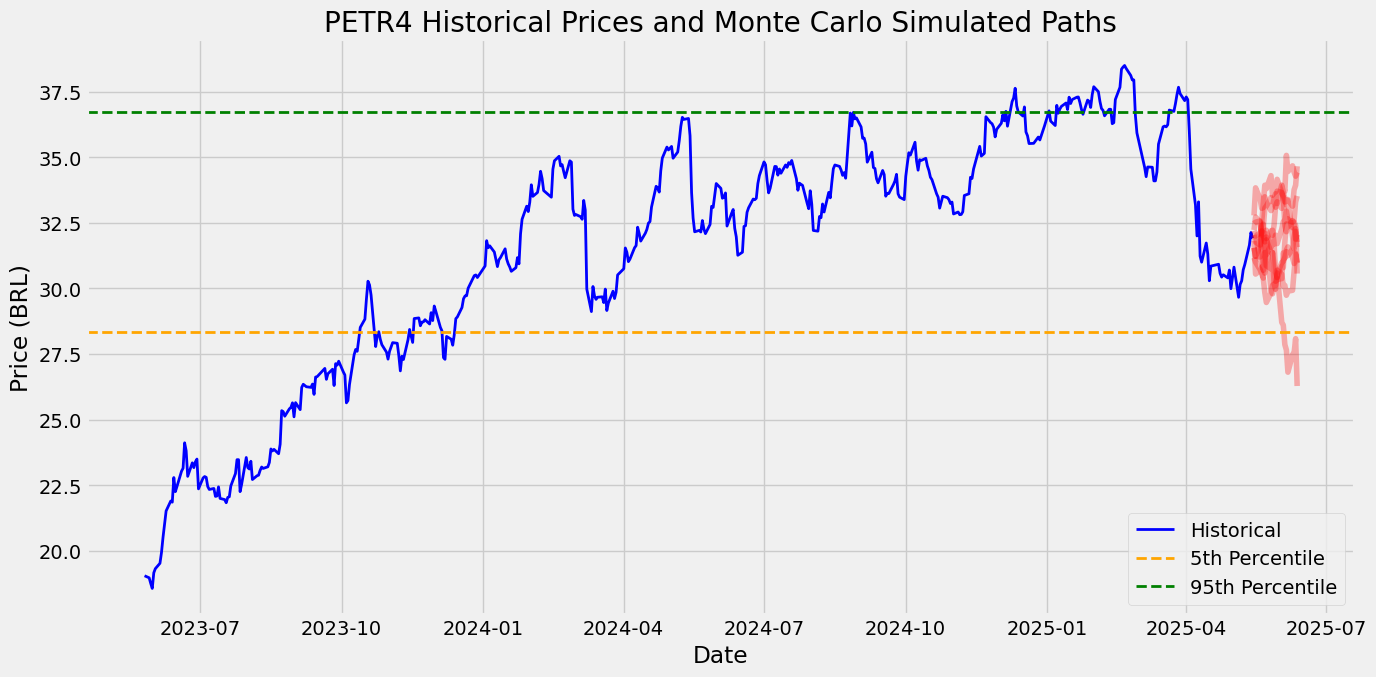

In [25]:
# Generate and plot some sample paths
def generate_sample_paths(S0, cdf_values, sorted_values, time_steps, num_paths=50):
    # Run smaller simulation just for visualization purposes
    np.random.seed(42)  # For reproducibility
    U = np.random.rand(time_steps, num_paths)
    Z = np.interp(U, cdf_values, sorted_values)
    factor = np.exp(Z)
    paths = S0 * np.cumprod(factor, axis=0)
    # Insert initial price at the beginning
    paths = np.vstack([np.ones(num_paths) * S0, paths])
    return paths

# Get historical prices for comparison
ddb_data = query_dolphindb()
if ddb_data is not None:
    df = ddb_data[ddb_data['Symbol'] == ticker]
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    today = datetime.now()
    start_date = (today - timedelta(days=period * 30)).strftime('%Y-%m-%d')
    historical_df = df[(df['Datetime'] >= start_date)].sort_values('Datetime')
    
    # Generate sample paths
    cdf_vals = results[ticker]['cdf_values']['interpolated_cdf_values']
    sorted_vals = results[ticker]['cdf_values']['sorted_values']
    S0 = results[ticker]['cdf_values']['S0']
    sample_paths = generate_sample_paths(S0, cdf_vals, sorted_vals, time_steps, num_paths=10)
    
    # Create timeline for future projections
    last_date = historical_df['Datetime'].max()
    future_dates = pd.date_range(start=last_date, periods=time_steps+1, freq='B')[1:]
    all_dates = pd.concat([historical_df['Datetime'], pd.Series(future_dates)])
    
    # Plot historical and projected paths
    plt.figure(figsize=(14, 7))
    
    # Plot historical data
    plt.plot(historical_df['Datetime'], historical_df['AdjClose'], 'b-', linewidth=2, label='Historical')
    
    # Plot projected paths
    for i in range(sample_paths.shape[1]):
        plt.plot(future_dates, sample_paths[1:, i], 'r-', alpha=0.3)
        
    # Highlight the boundaries (5th and 95th percentiles)
    plt.axhline(y=mc_stats['percentiles']['5%'], color='orange', linestyle='--', linewidth=2, label='5th Percentile')
    plt.axhline(y=mc_stats['percentiles']['95%'], color='green', linestyle='--', linewidth=2, label='95th Percentile')
    
    plt.title(f'{ticker} Historical Prices and Monte Carlo Simulated Paths')
    plt.xlabel('Date')
    plt.ylabel('Price (BRL)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Unable to fetch historical data for comparison.")

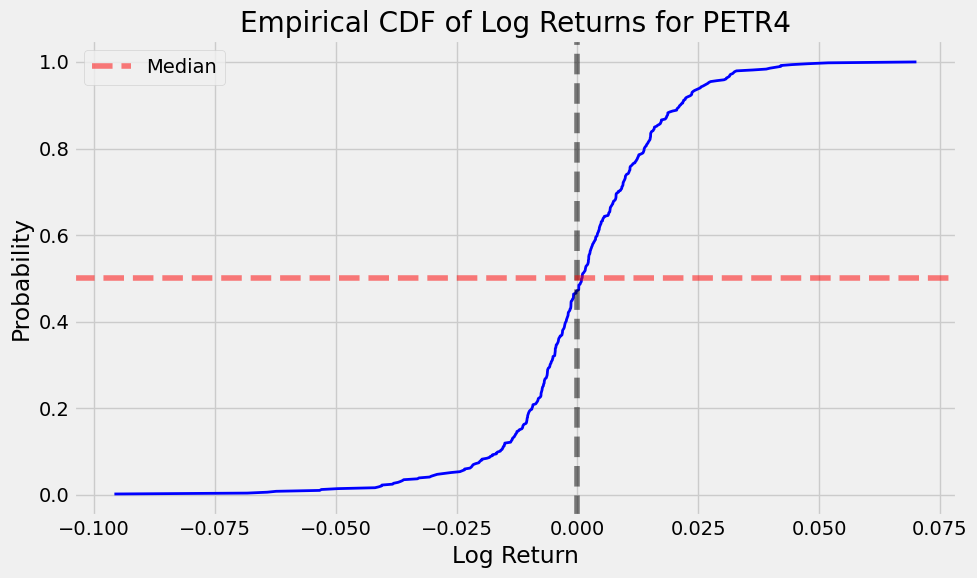

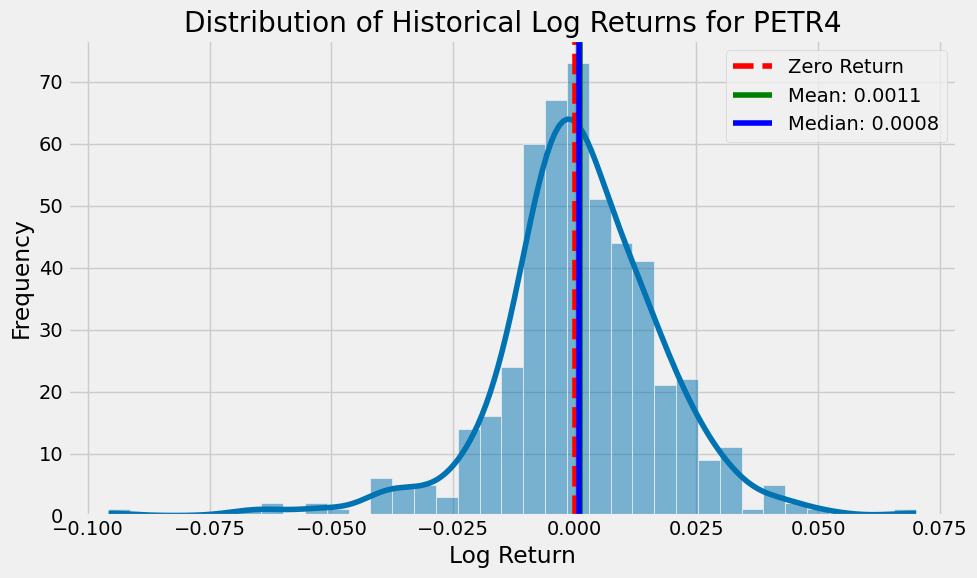

In [26]:
# Plot the empirical CDF used for the bootstrap
plt.figure(figsize=(10, 6))

sorted_vals = results[ticker]['cdf_values']['sorted_values']
cdf_vals = results[ticker]['cdf_values']['interpolated_cdf_values']

plt.plot(sorted_vals, cdf_vals, 'b-', linewidth=2)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Median')

plt.title(f'Empirical CDF of Log Returns for {ticker}')
plt.xlabel('Log Return')
plt.ylabel('Probability')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot histogram of historical returns
plt.figure(figsize=(10, 6))
log_returns = pd.Series(results[ticker]['returns']['log_return'])
sns.histplot(log_returns, kde=True)
plt.axvline(x=0, color='r', linestyle='--', label='Zero Return')
plt.axvline(x=log_returns.mean(), color='g', linestyle='-', label=f'Mean: {log_returns.mean():.4f}')
plt.axvline(x=log_returns.median(), color='b', linestyle='-', label=f'Median: {log_returns.median():.4f}')

plt.title(f'Distribution of Historical Log Returns for {ticker}')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

c:\Users\ojuar\.conda\envs\backenv\lib\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


Best fitting distribution: t
Parameters: (139.47987320395174, 32.59383994516797, 2.511326067785543)
Kolmogorov-Smirnov statistic: 0.0093
P-value: 0.7769


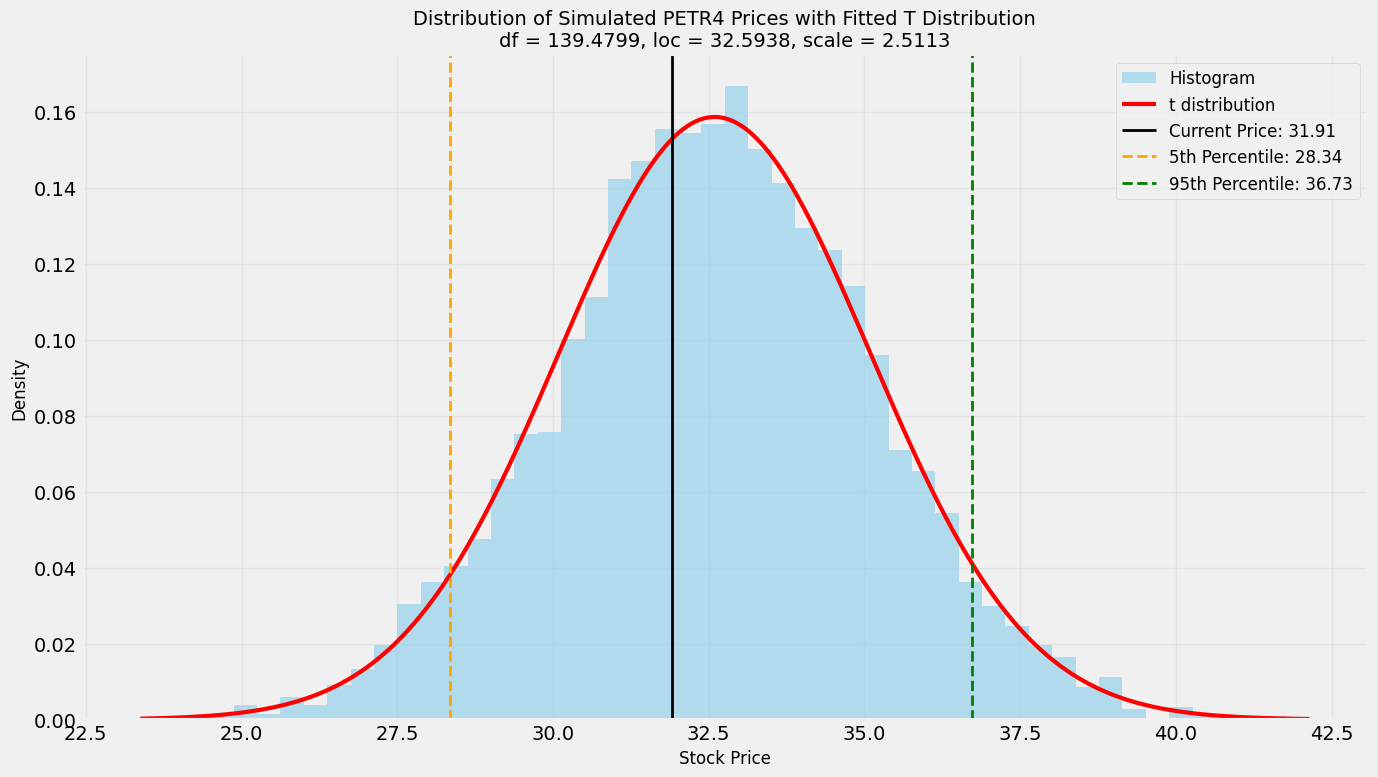


Top 3 distributions:
1. t - KS statistic: 0.0093, p-value: 0.7769
2. beta - KS statistic: 0.0101, p-value: 0.6890
3. norm - KS statistic: 0.0103, p-value: 0.6590


In [27]:
# Find the best distribution fit for arrival values
import scipy.stats as st

# Define distributions to test
distributions = [
    st.norm, st.lognorm, st.gamma, st.weibull_min, st.t, st.beta,
    st.expon, st.chi2, st.rayleigh, st.logistic
]
# Note: st.t is already the Student's t-distribution in SciPy

# Get arrival values from Monte Carlo simulation
arrival_values = np.array(results[ticker]['monte_carlo']['all_arrivals'])

# Function to calculate goodness of fit
def find_best_distribution(data, distributions):
    results = {}
    for distribution in distributions:
        # Fit distribution to data
        params = distribution.fit(data)
        
        # Calculate goodness of fit using Kolmogorov-Smirnov test
        # Lower D statistic = better fit
        D, p_value = st.kstest(data, distribution.name, params)
        
        # Store results
        results[distribution.name] = {
            'distribution': distribution,
            'params': params,
            'D': D,
            'p_value': p_value
        }
    
    # Sort by lowest D statistic (best fit)
    best_fits = sorted(results.items(), key=lambda x: x[1]['D'])
    return best_fits

# Find best distribution
best_fits = find_best_distribution(arrival_values, distributions)

# Get the best fit
best_dist_name, best_dist_data = best_fits[0]
best_dist = best_dist_data['distribution']
best_params = best_dist_data['params']
D_stat = best_dist_data['D']
p_value = best_dist_data['p_value']

print(f"Best fitting distribution: {best_dist_name}")
print(f"Parameters: {best_params}")
print(f"Kolmogorov-Smirnov statistic: {D_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Extract parameters for specific distributions (handling different parameter structures)
if best_dist_name == 'norm':
    loc, scale = best_params
    param_str = f"μ = {loc:.4f}, σ = {scale:.4f}"
elif best_dist_name == 'lognorm':
    shape, loc, scale = best_params  # s, loc, scale
    param_str = f"s = {shape:.4f}, loc = {loc:.4f}, scale = {scale:.4f}"
elif best_dist_name == 'gamma':
    a, loc, scale = best_params
    param_str = f"α = {a:.4f}, loc = {loc:.4f}, scale = {scale:.4f}"
elif best_dist_name == 't':
    df, loc, scale = best_params
    param_str = f"df = {df:.4f}, loc = {loc:.4f}, scale = {scale:.4f}"
else:
    param_str = f"Parameters: {best_params}"

# Plot histogram with fitted distribution
plt.figure(figsize=(14, 8))

# Plot histogram
hist_data = plt.hist(arrival_values, bins=50, density=True, alpha=0.6, 
                    color='skyblue', label='Histogram')

# Generate points for distribution curve
x = np.linspace(arrival_values.min(), arrival_values.max(), 1000)
pdf = best_dist.pdf(x, *best_params)

# Plot fitted distribution
plt.plot(x, pdf, 'r-', linewidth=3, label=f'{best_dist_name} distribution')

# Add vertical lines for key statistics
plt.axvline(current_price, color='black', linestyle='-', linewidth=2, 
           label=f'Current Price: {current_price:.2f}')
plt.axvline(mc_stats['percentiles']['5%'], color='orange', linestyle='--', linewidth=2, 
           label=f'5th Percentile: {mc_stats["percentiles"]["5%"]:.2f}')
plt.axvline(mc_stats['percentiles']['95%'], color='green', linestyle='--', linewidth=2, 
           label=f'95th Percentile: {mc_stats["percentiles"]["95%"]:.2f}')

# Add title and labels
plt.title(f'Distribution of Simulated {ticker} Prices with Fitted {best_dist_name.capitalize()} Distribution\n{param_str}', fontsize=14)
plt.xlabel('Stock Price', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Print top 3 distributions
print("\nTop 3 distributions:")
for i, (dist_name, dist_data) in enumerate(best_fits[:3]):
    print(f"{i+1}. {dist_name} - KS statistic: {dist_data['D']:.4f}, p-value: {dist_data['p_value']:.4f}")

Running simulations for PETR4 with varying time steps...
This may take some time to complete.

Running simulation with time_steps = 5...
Best fit: logistic, KS statistic: 0.0079
Second best: beta, KS statistic: 0.0181
Elapsed time: 13.30 seconds

Running simulation with time_steps = 10...
Best fit: beta, KS statistic: 0.0103
Second best: norm, KS statistic: 0.0109
Elapsed time: 12.18 seconds

Running simulation with time_steps = 15...
Best fit: t, KS statistic: 0.0051
Second best: norm, KS statistic: 0.0052
Elapsed time: 10.78 seconds

Running simulation with time_steps = 20...
Best fit: t, KS statistic: 0.0045
Second best: lognorm, KS statistic: 0.0053
Elapsed time: 13.23 seconds

Running simulation with time_steps = 25...
Best fit: lognorm, KS statistic: 0.0036
Second best: gamma, KS statistic: 0.0037
Elapsed time: 10.12 seconds

Running simulation with time_steps = 30...
Best fit: lognorm, KS statistic: 0.0027
Second best: gamma, KS statistic: 0.0028
Elapsed time: 11.66 seconds

Run

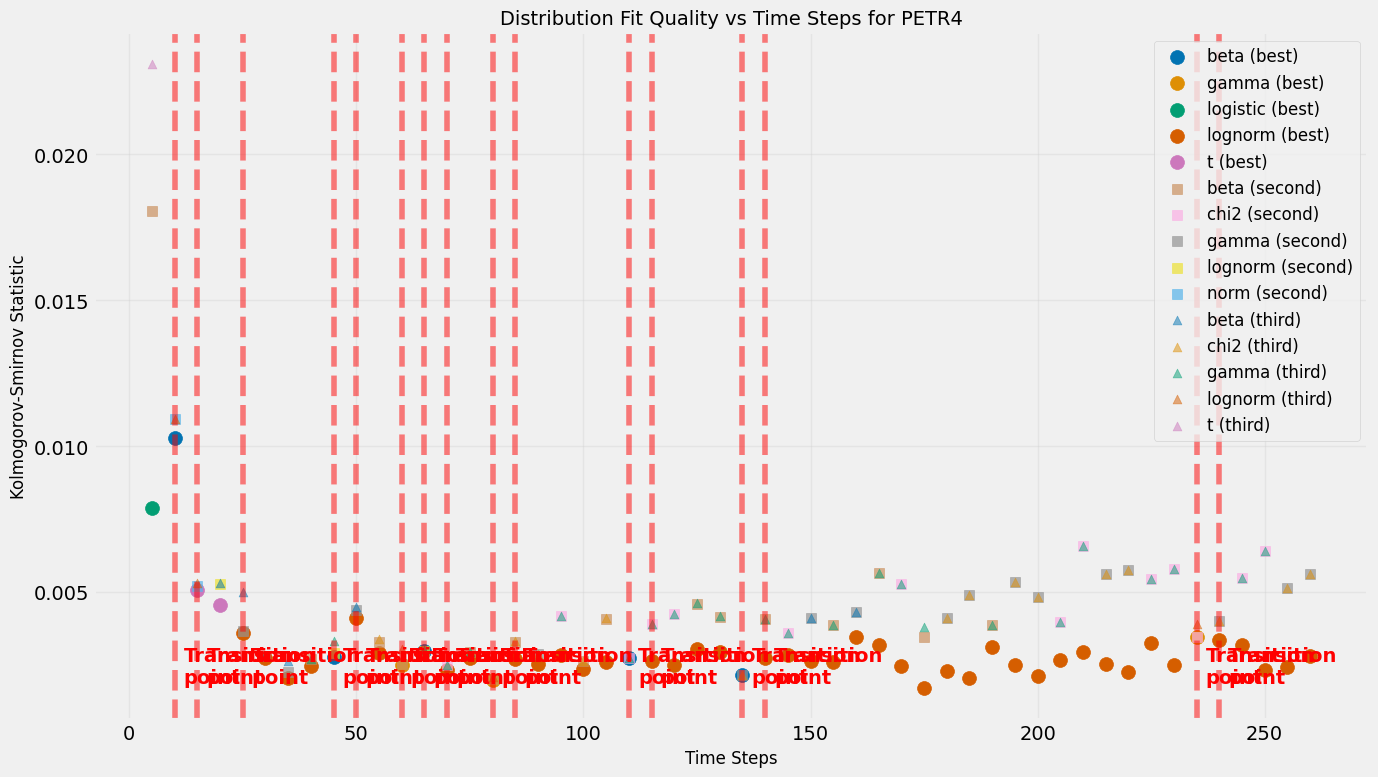


Generating visualization for time_steps = 5...


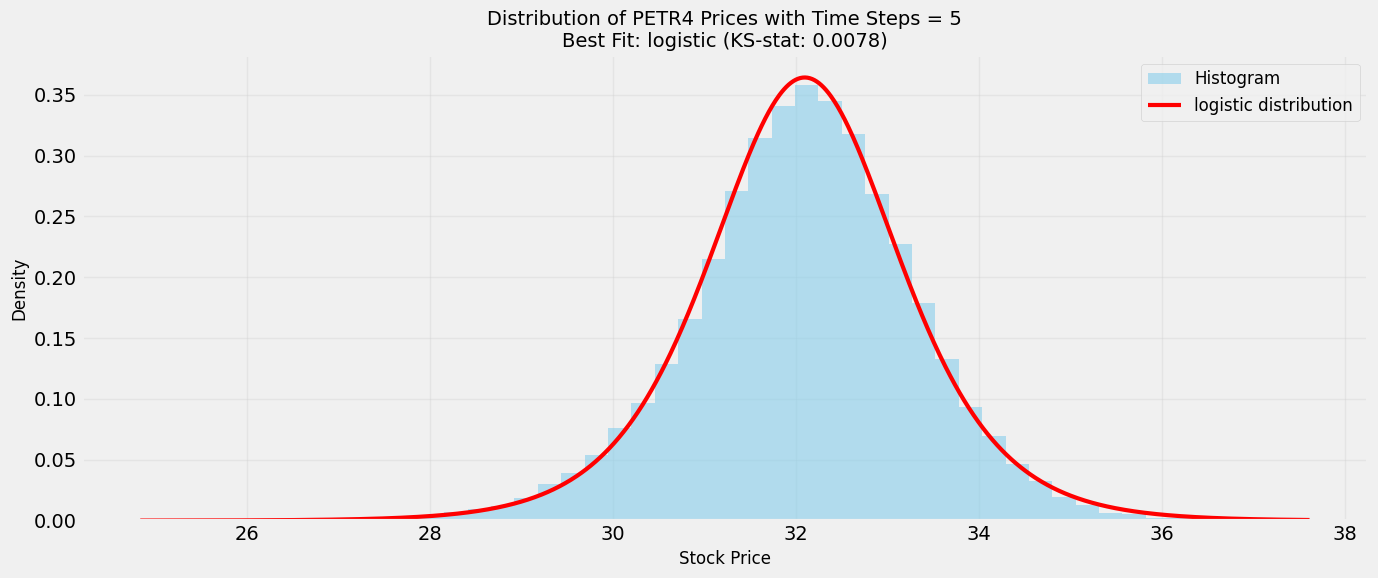


Generating visualization for time_steps = 10...


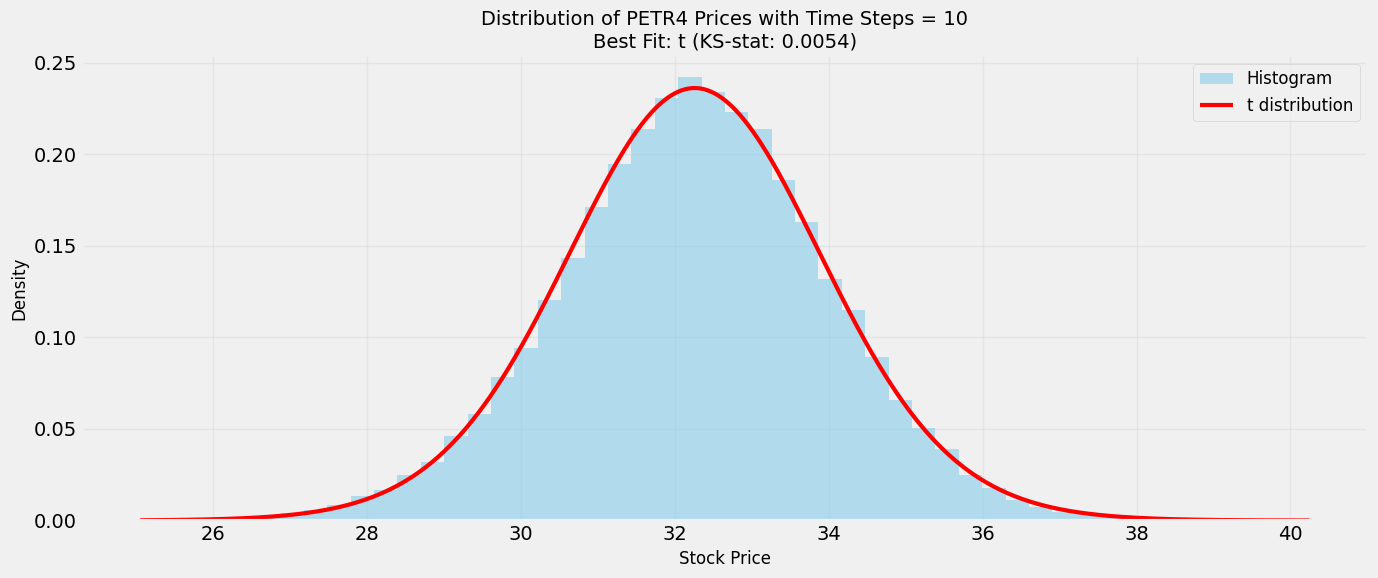


Generating visualization for time_steps = 10...


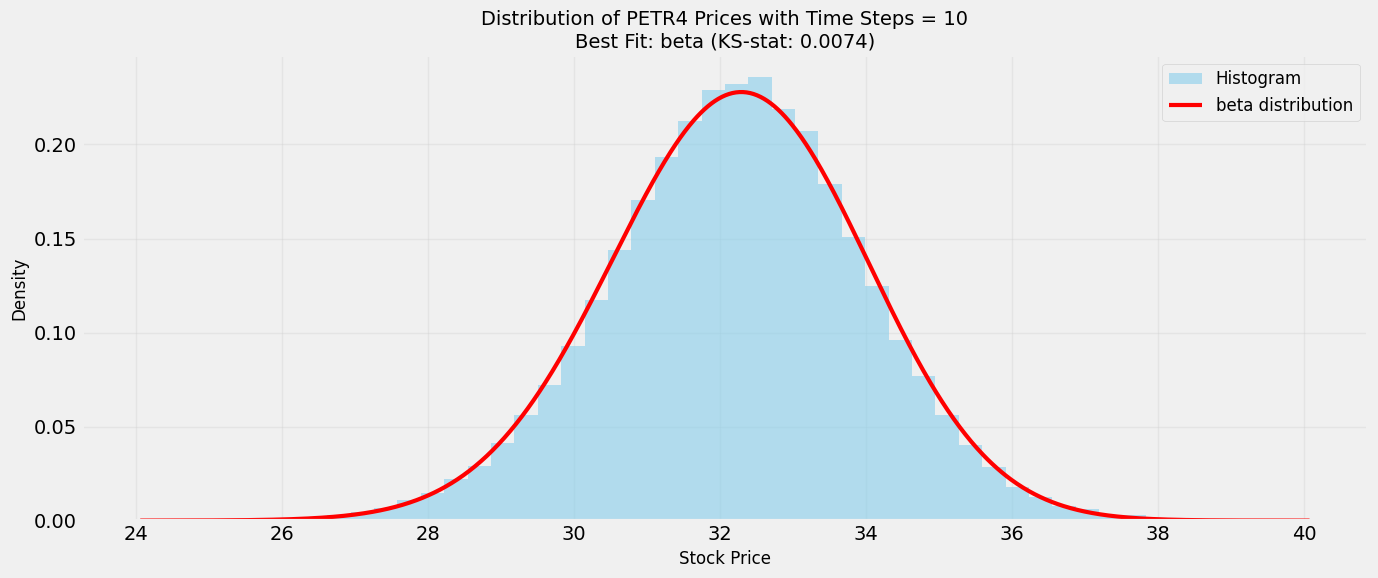


Generating visualization for time_steps = 15...


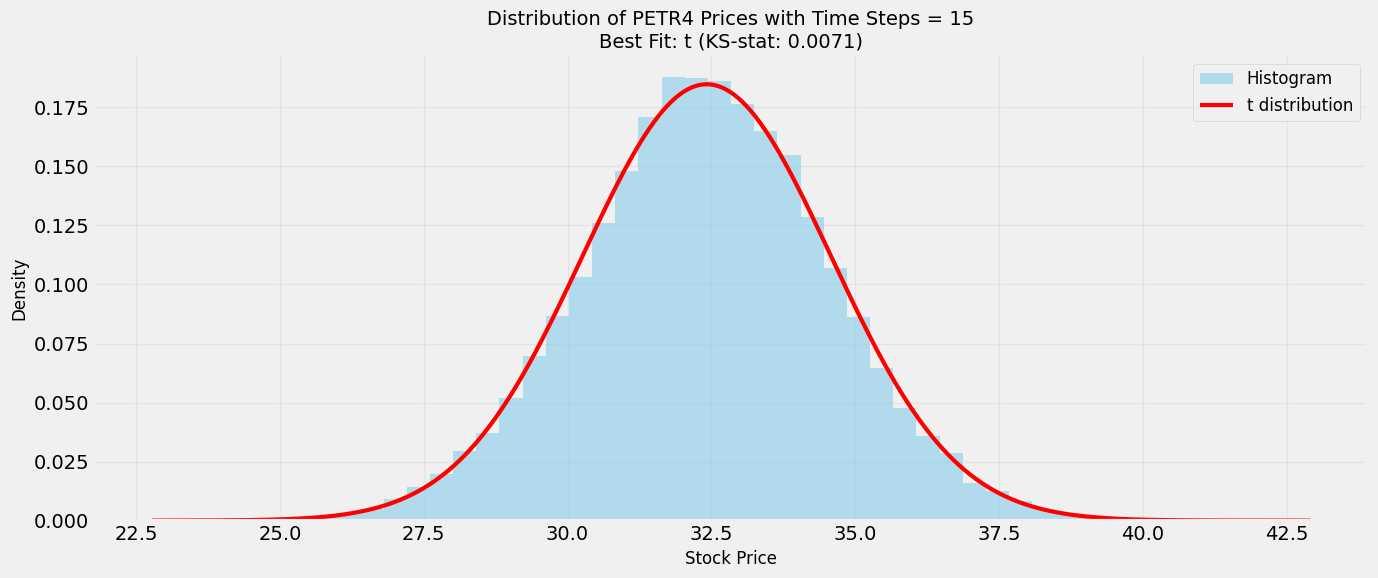


Generating visualization for time_steps = 20...


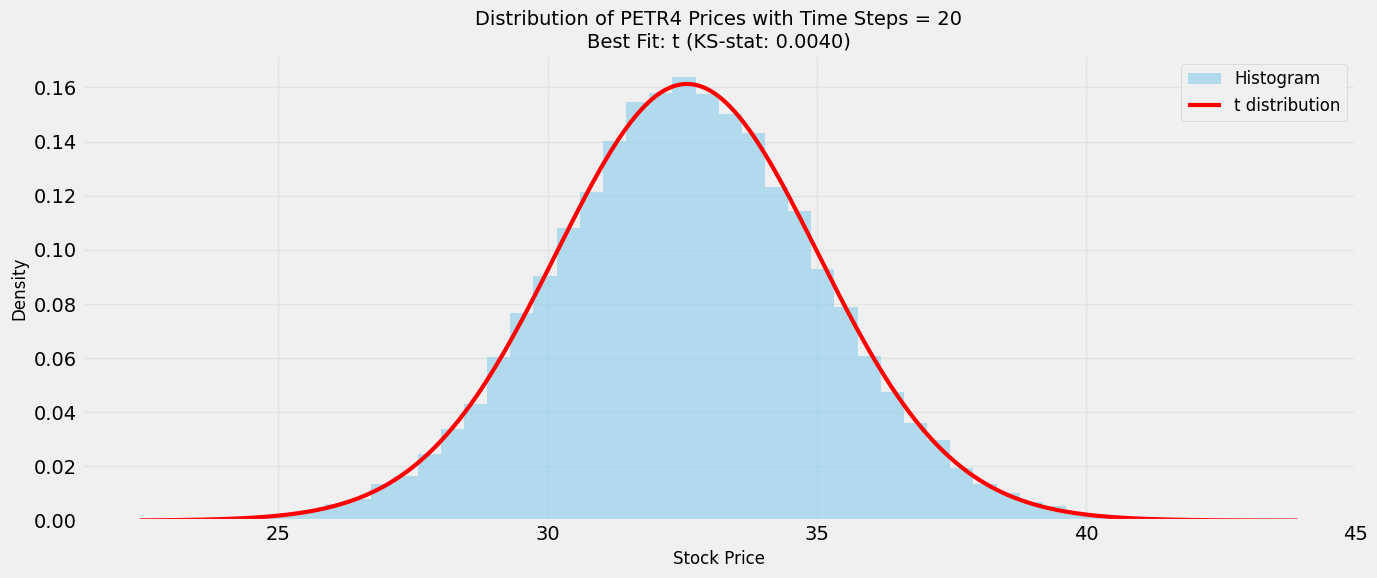


Generating visualization for time_steps = 25...


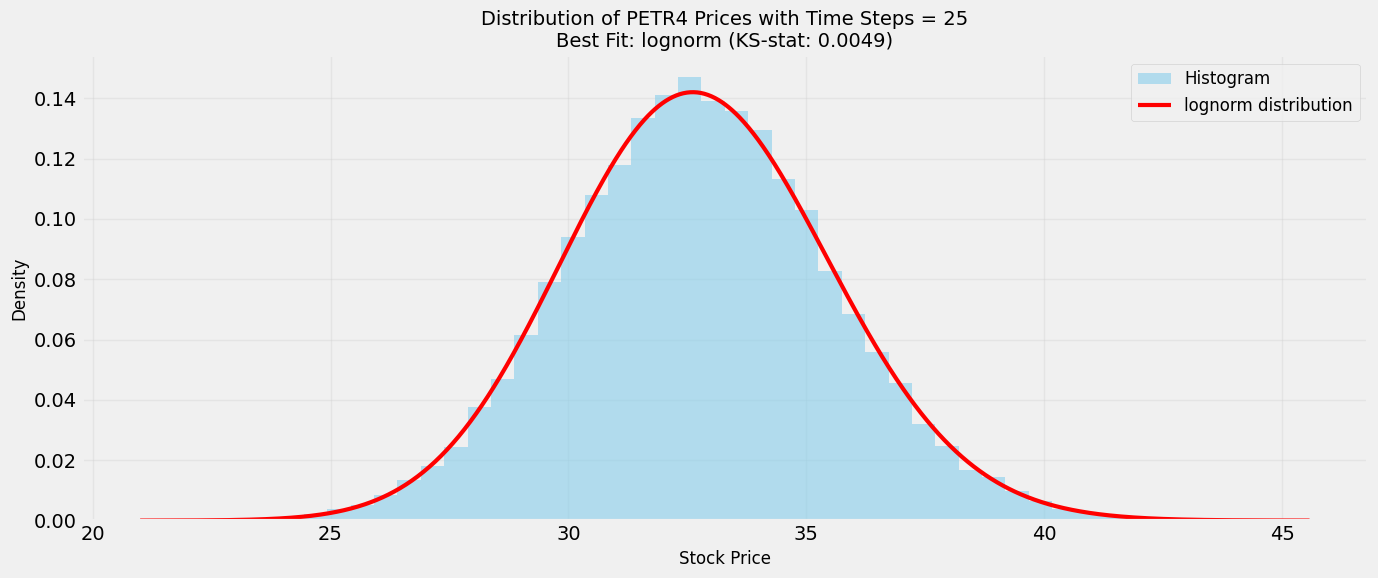


Generating visualization for time_steps = 40...


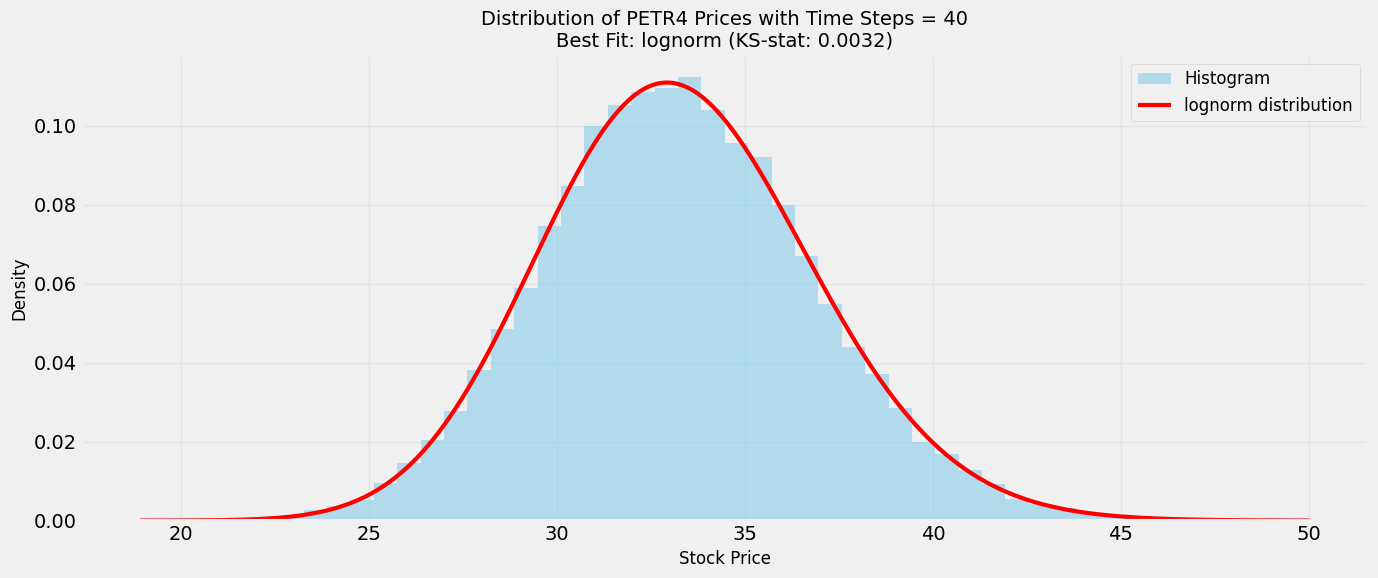


Generating visualization for time_steps = 45...


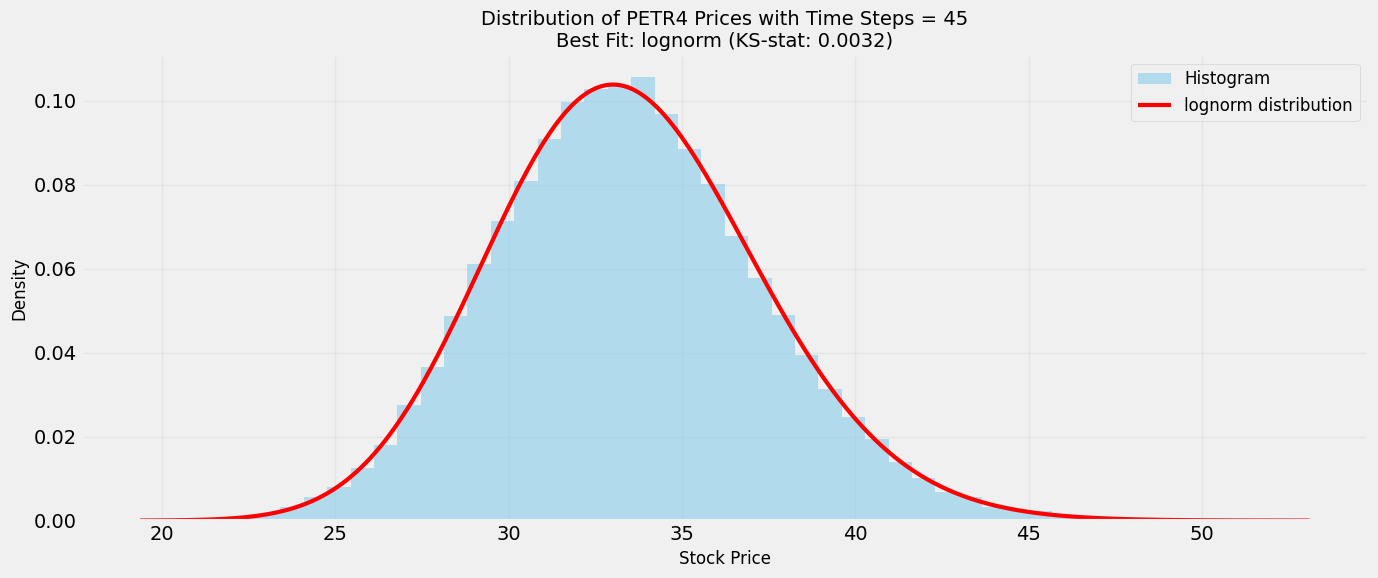


Generating visualization for time_steps = 45...


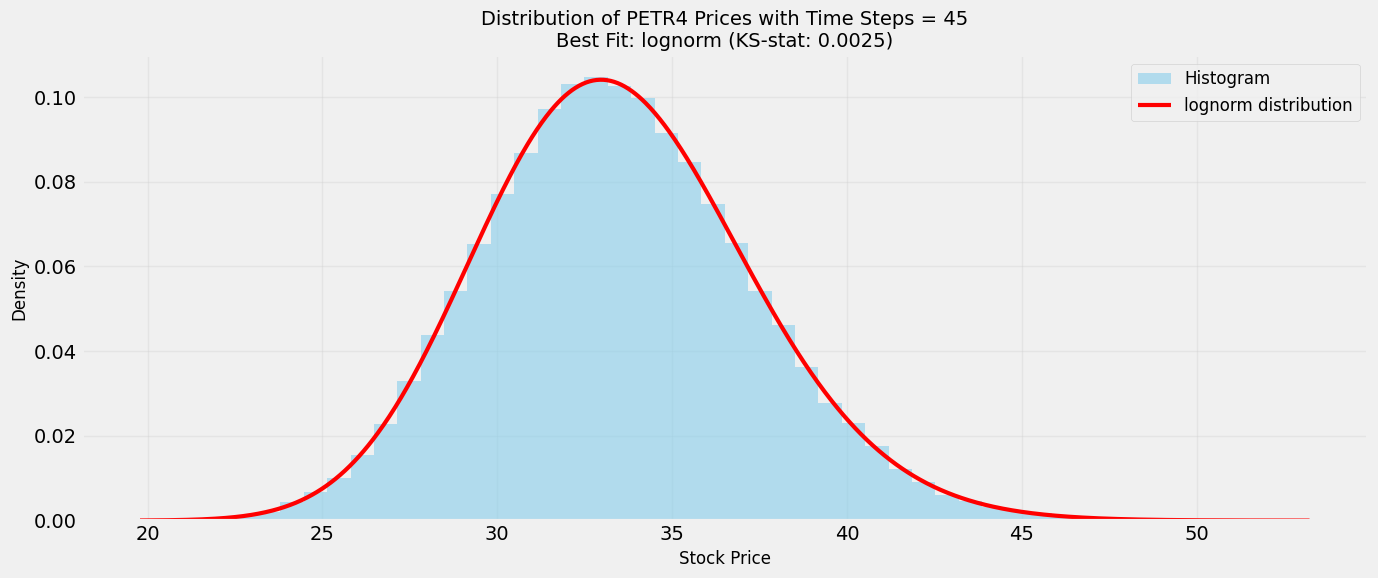


Generating visualization for time_steps = 50...


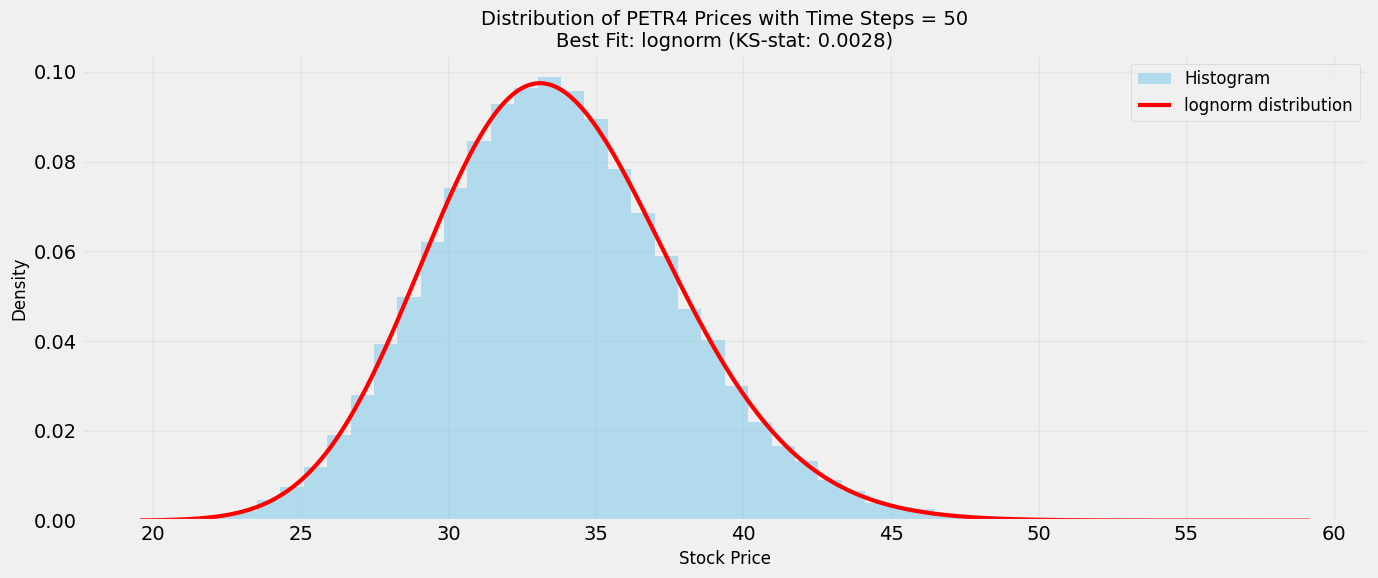


Generating visualization for time_steps = 55...


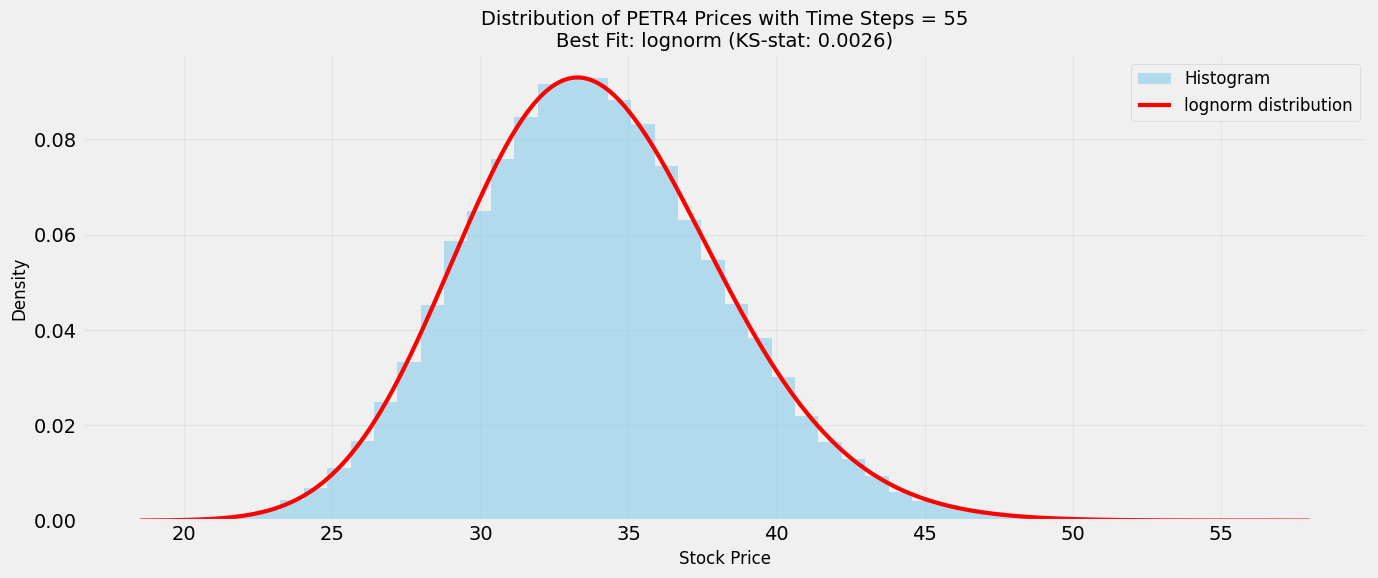


Generating visualization for time_steps = 60...


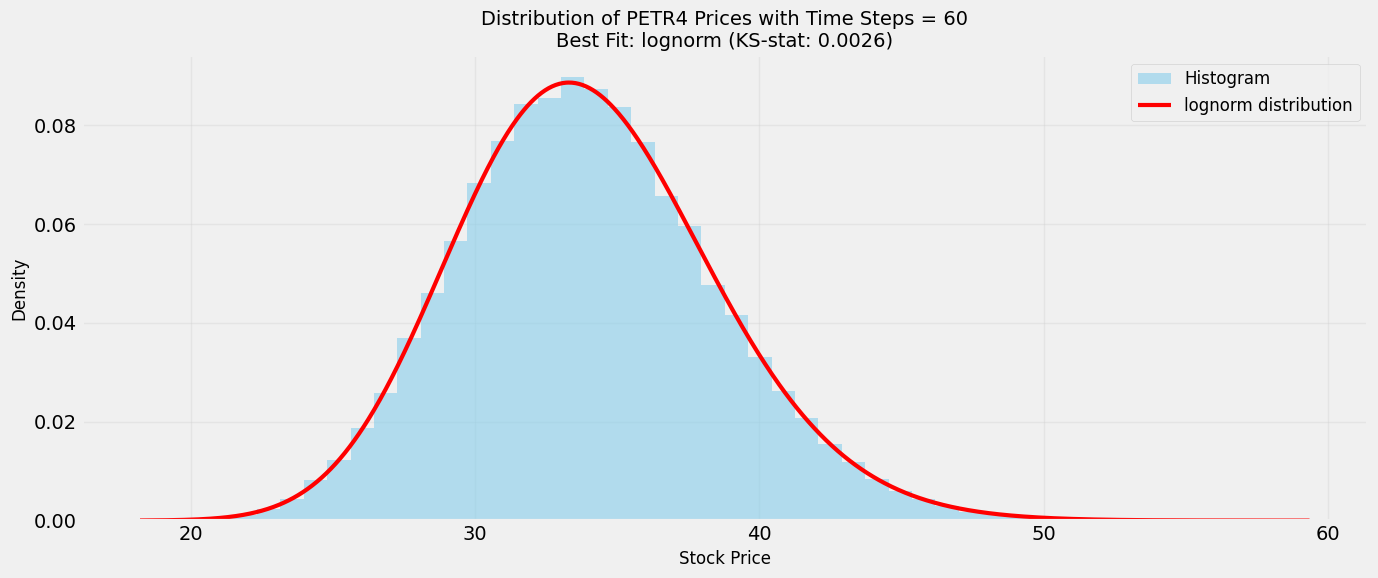


Generating visualization for time_steps = 60...


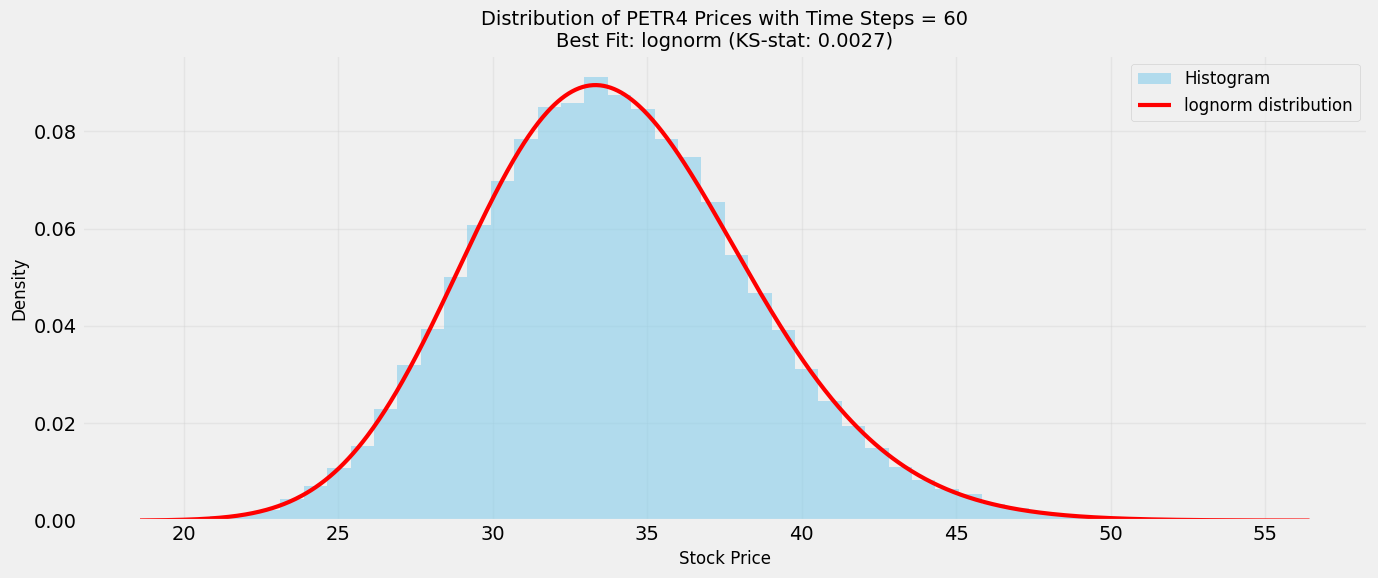


Generating visualization for time_steps = 65...


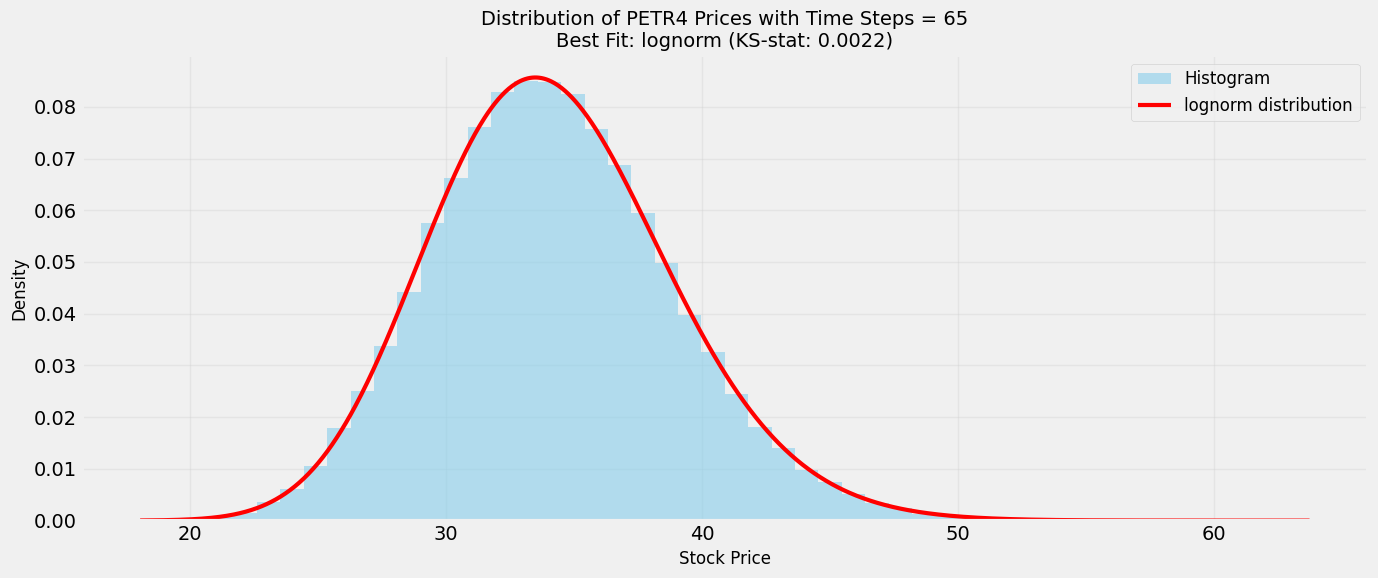


Generating visualization for time_steps = 65...


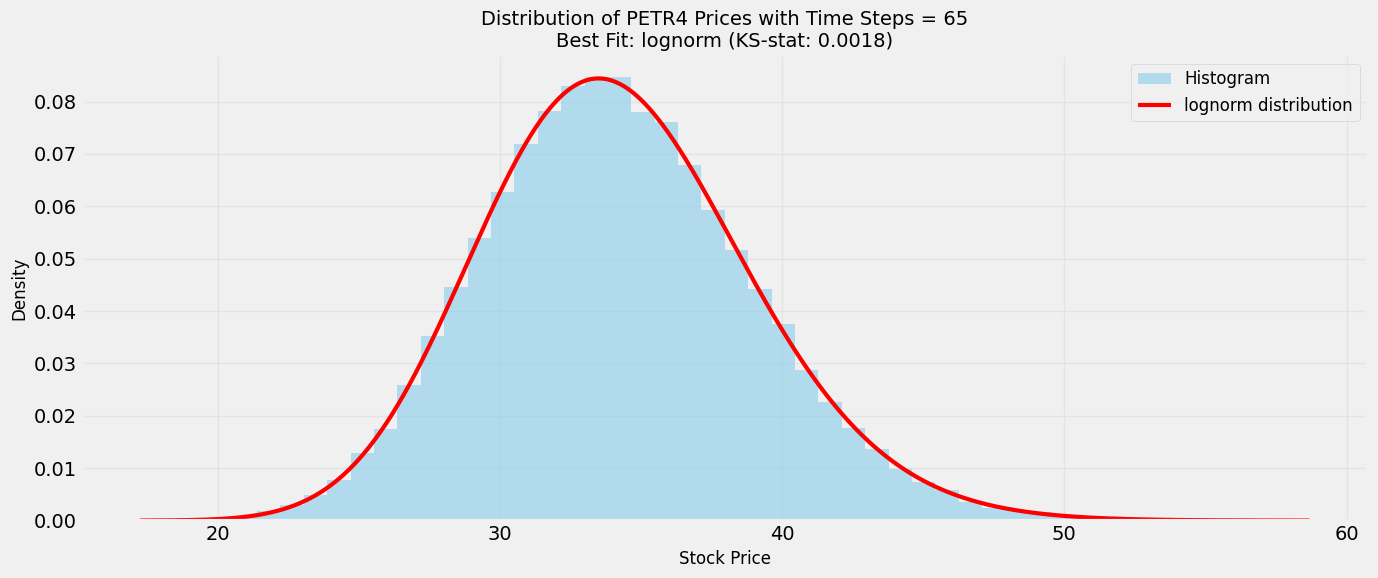


Generating visualization for time_steps = 70...


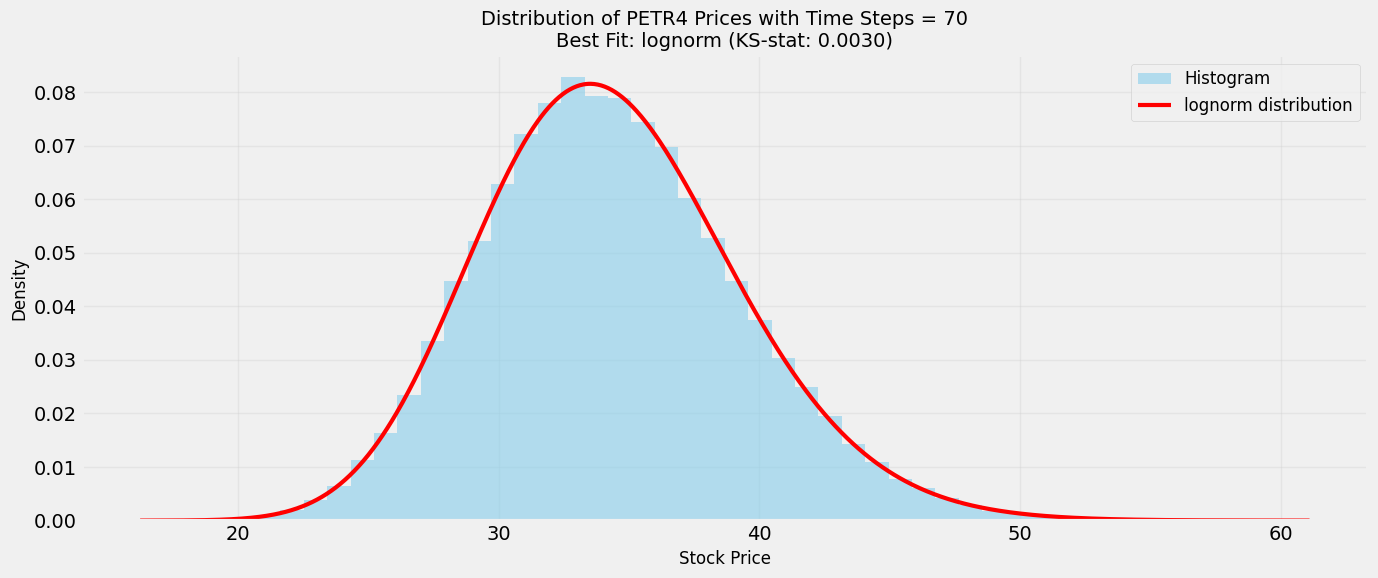


Generating visualization for time_steps = 75...


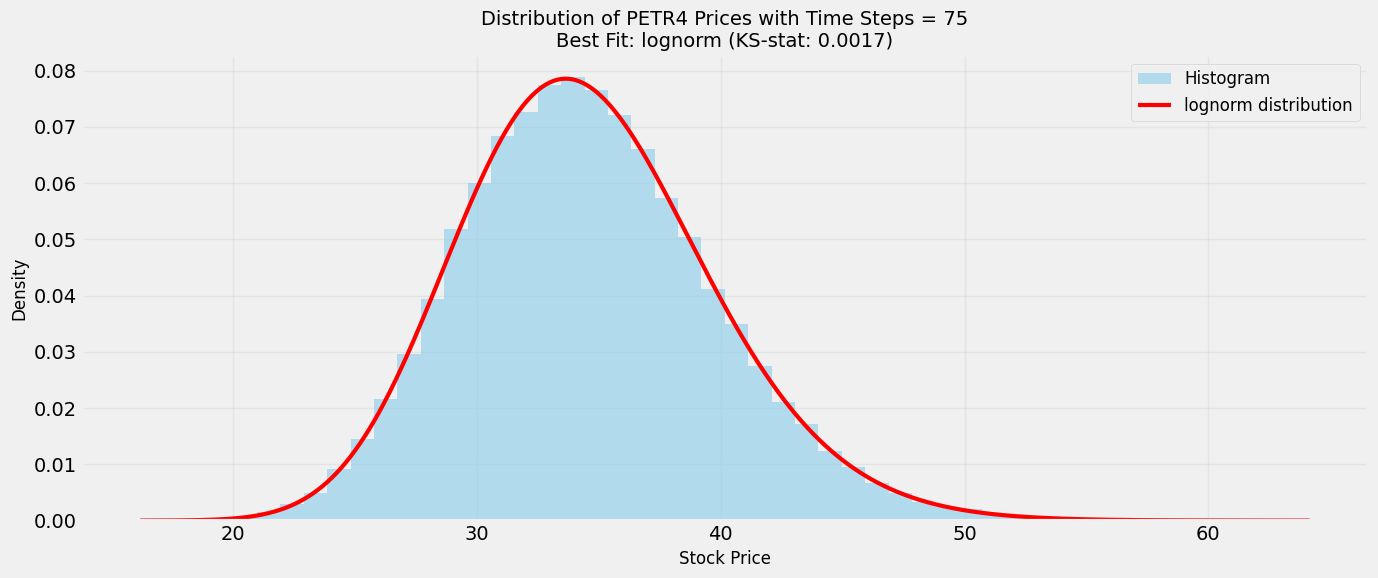


Generating visualization for time_steps = 80...


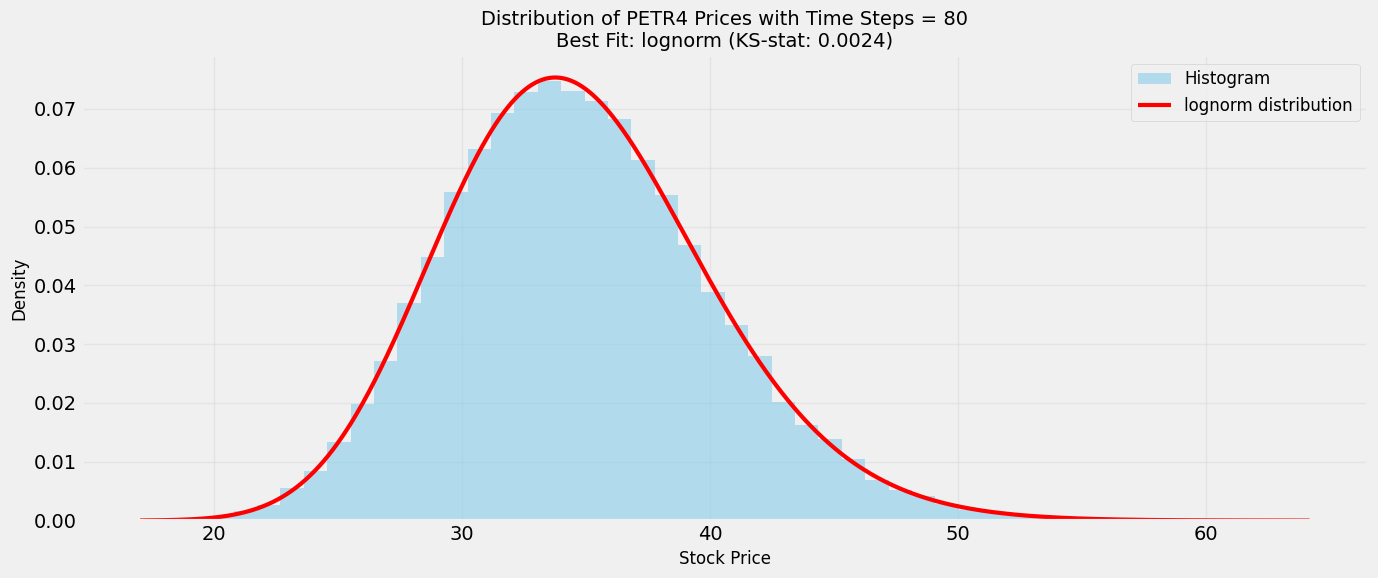


Generating visualization for time_steps = 80...


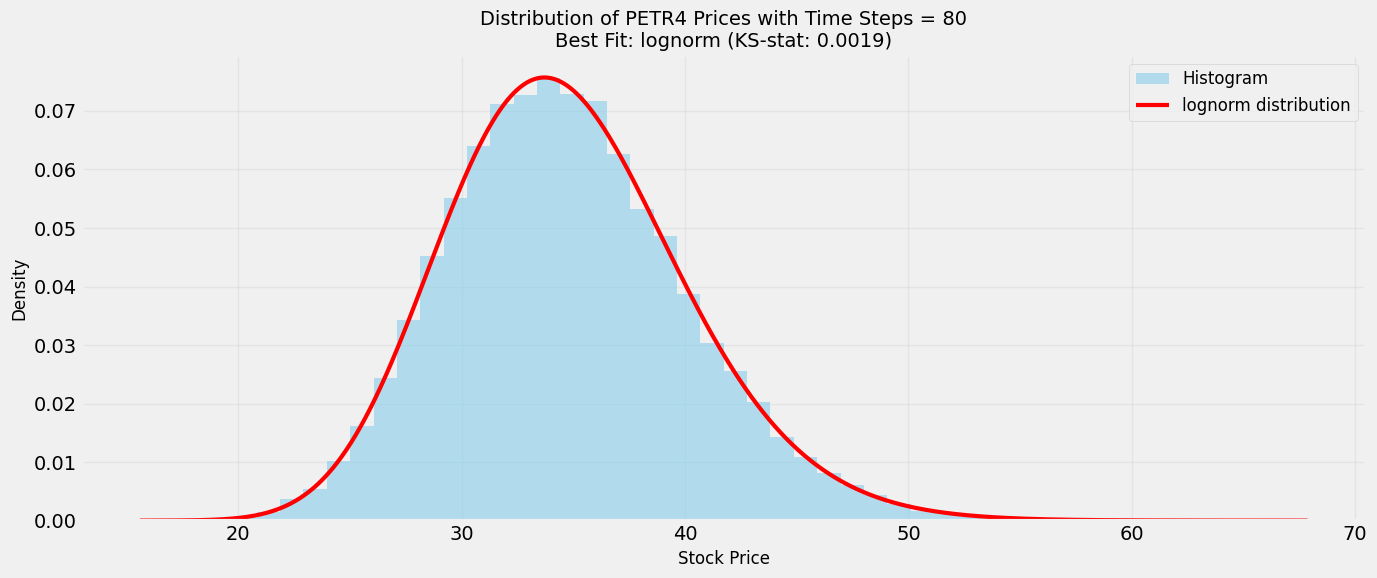


Generating visualization for time_steps = 85...


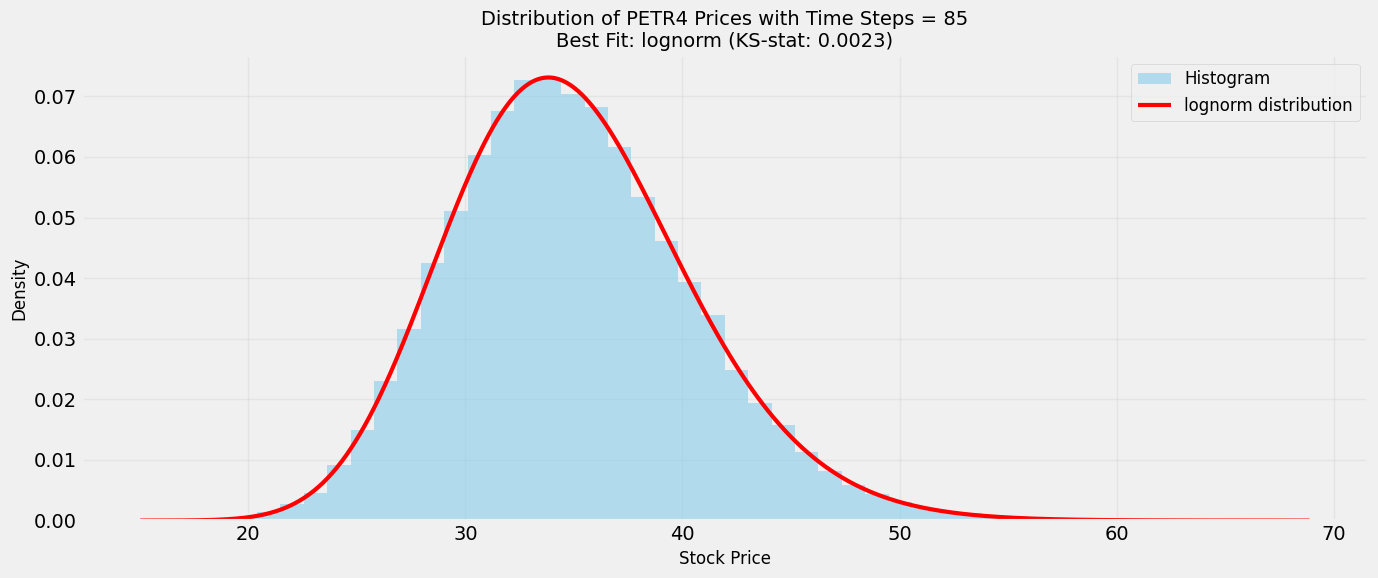


Generating visualization for time_steps = 105...


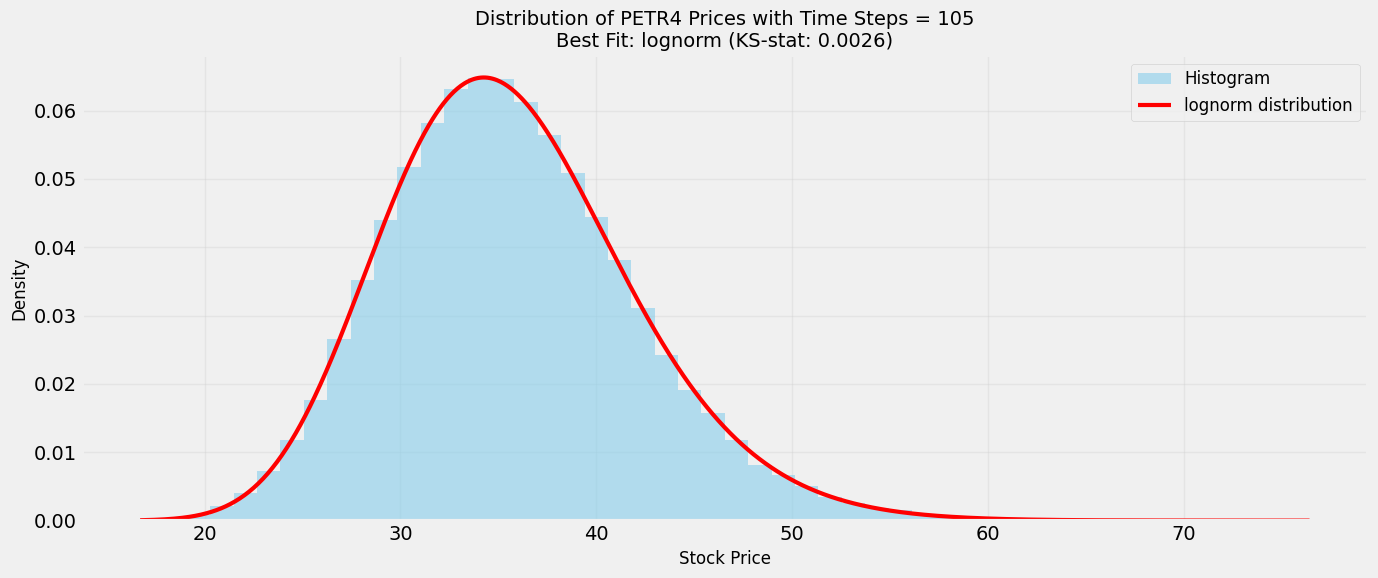


Generating visualization for time_steps = 110...


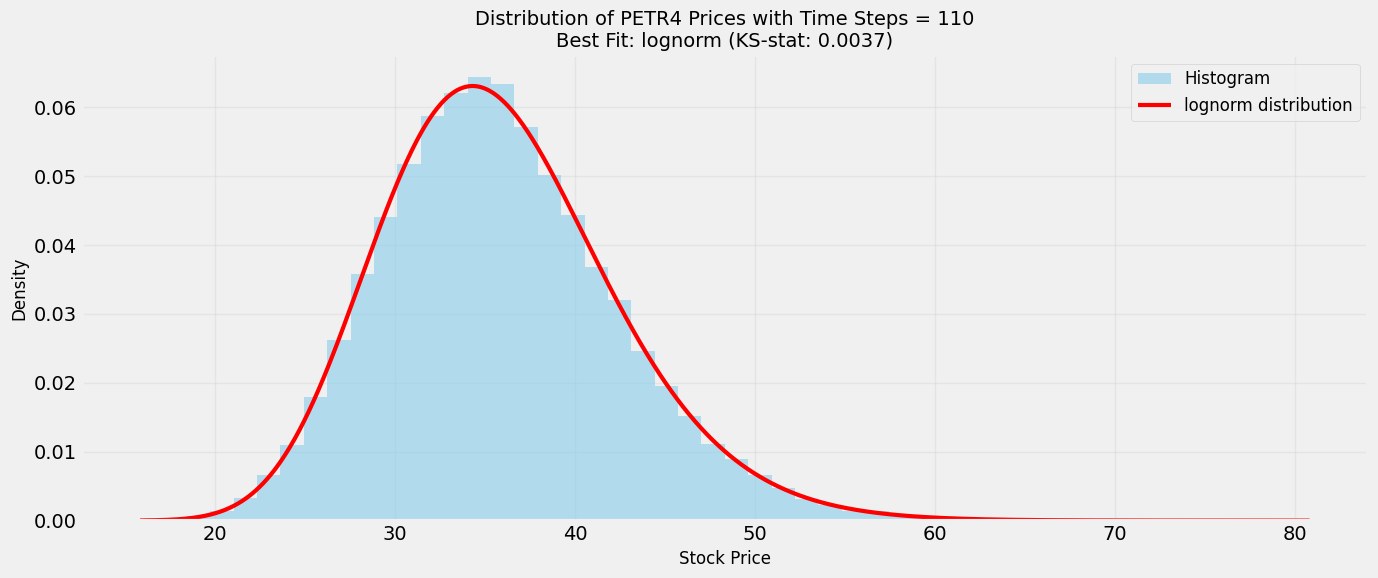


Generating visualization for time_steps = 110...


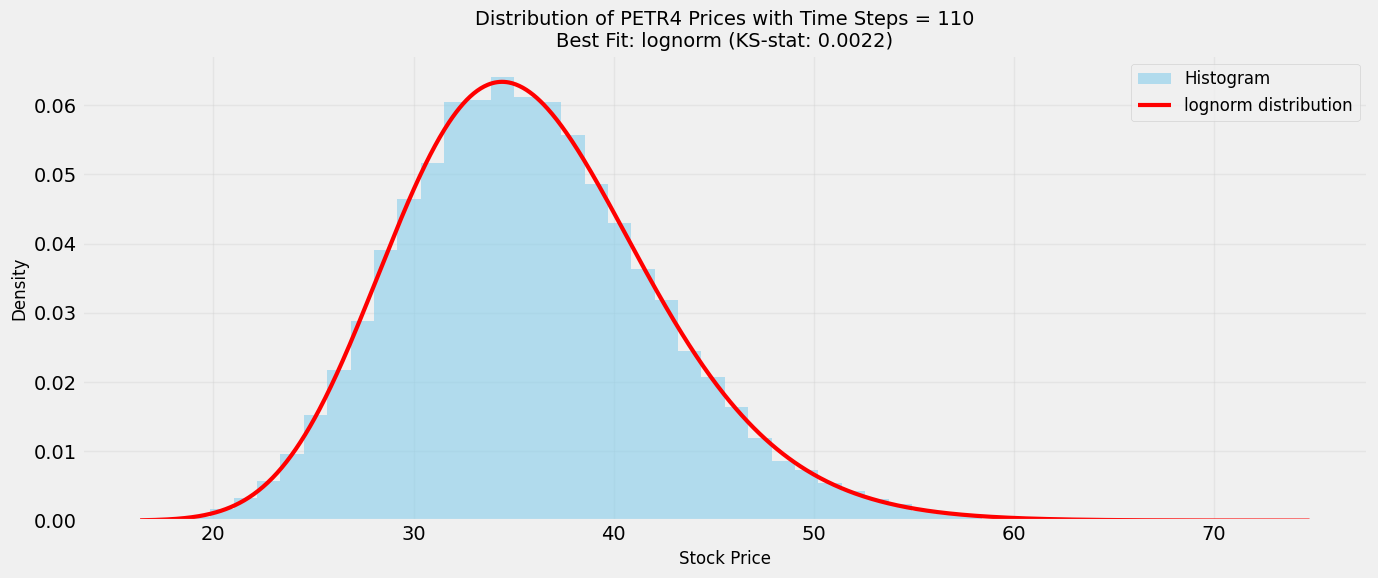


Generating visualization for time_steps = 115...


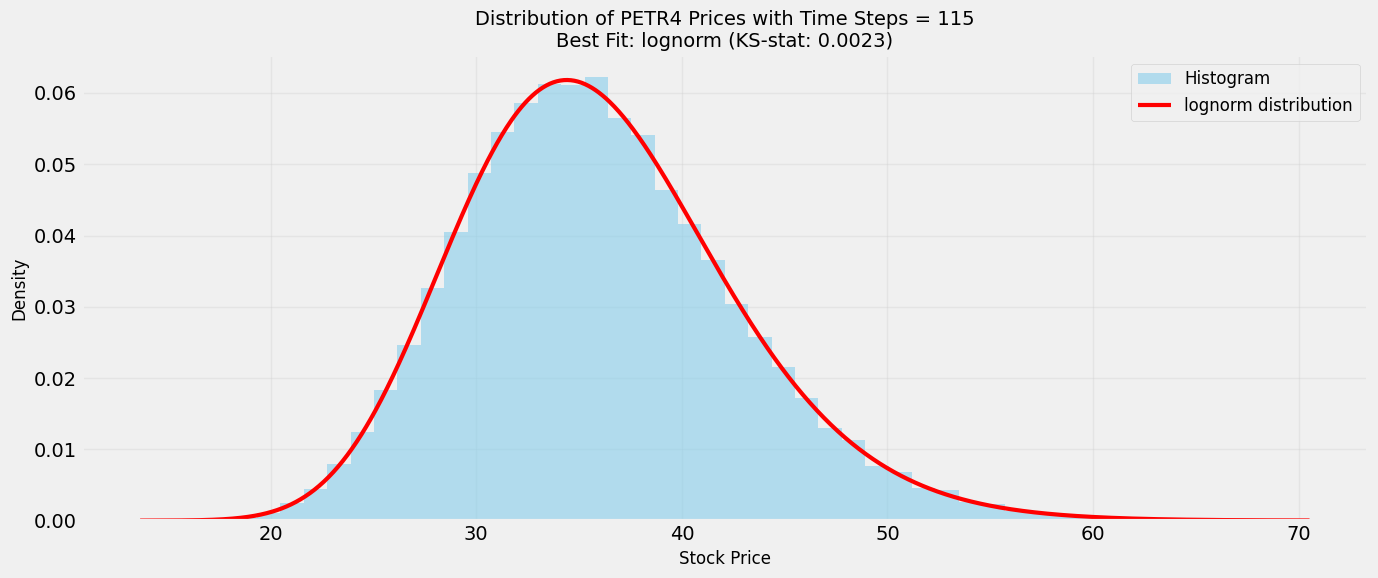


Generating visualization for time_steps = 130...


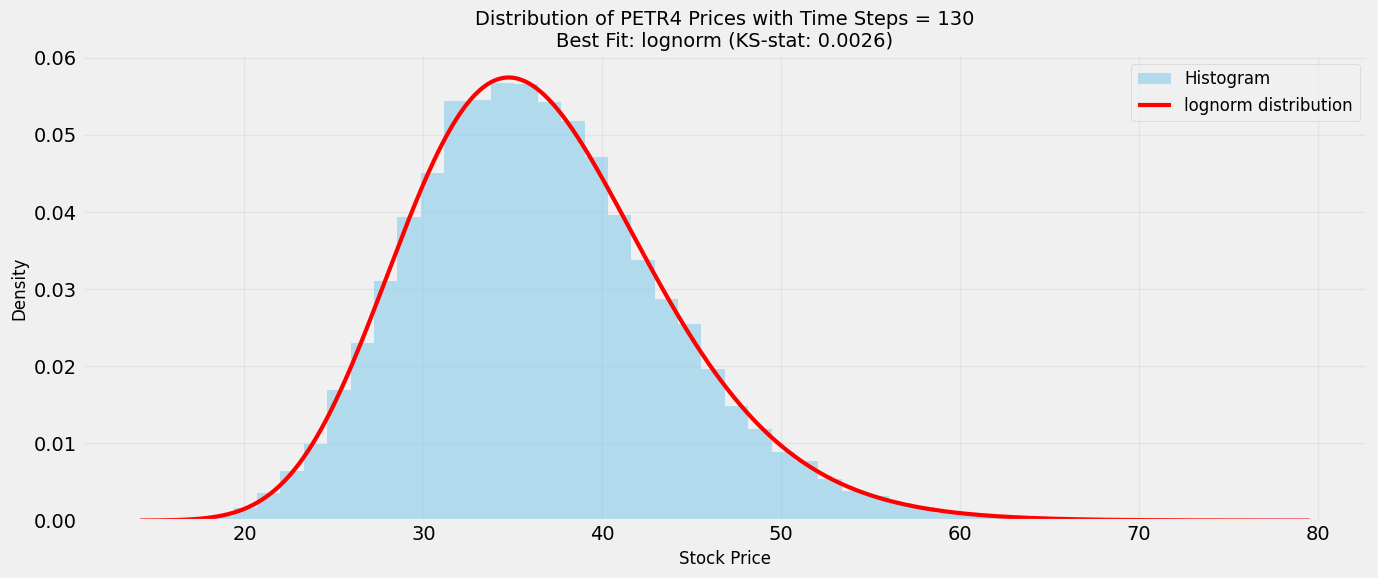


Generating visualization for time_steps = 135...


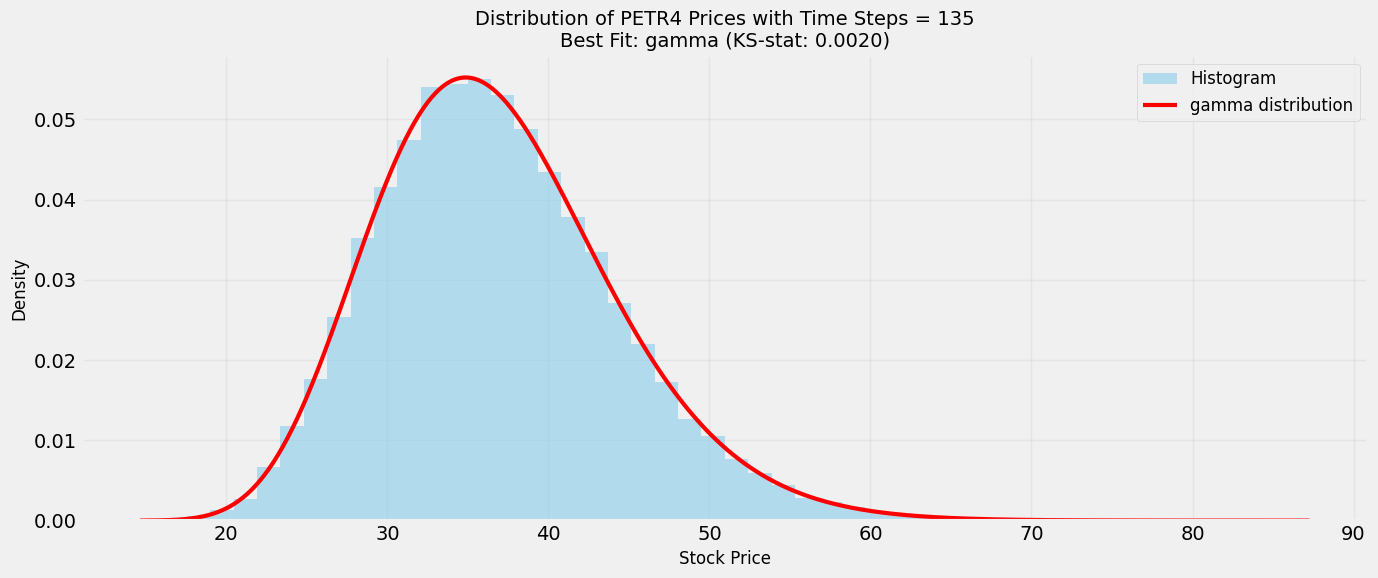


Generating visualization for time_steps = 135...


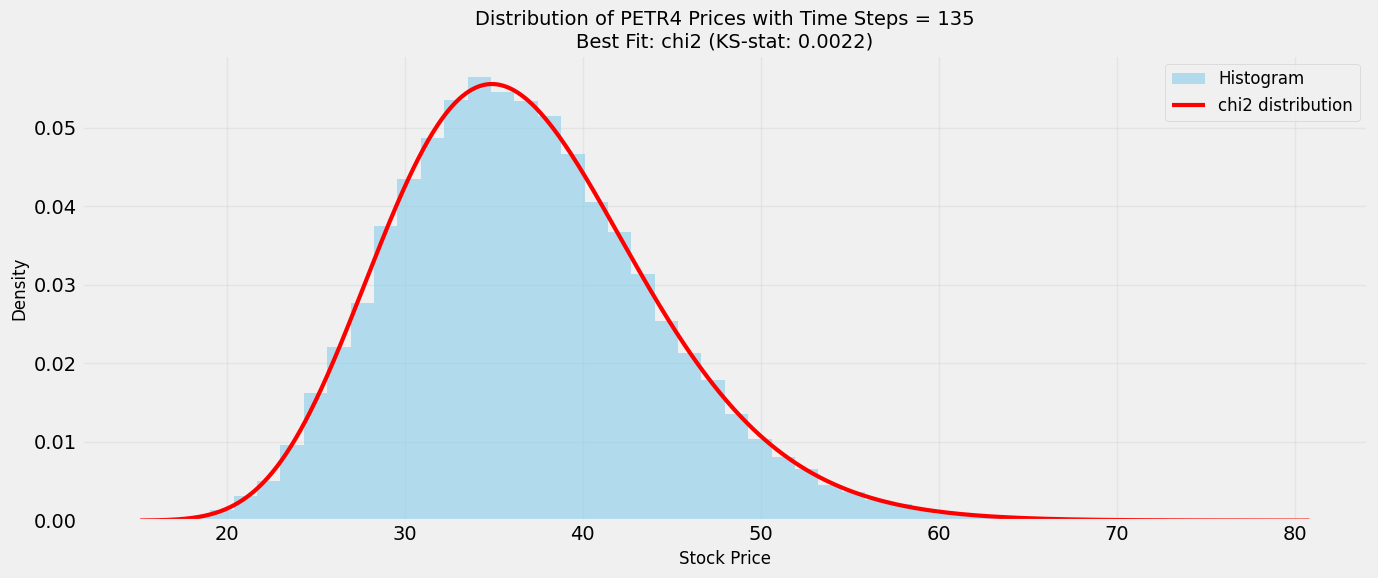


Generating visualization for time_steps = 140...


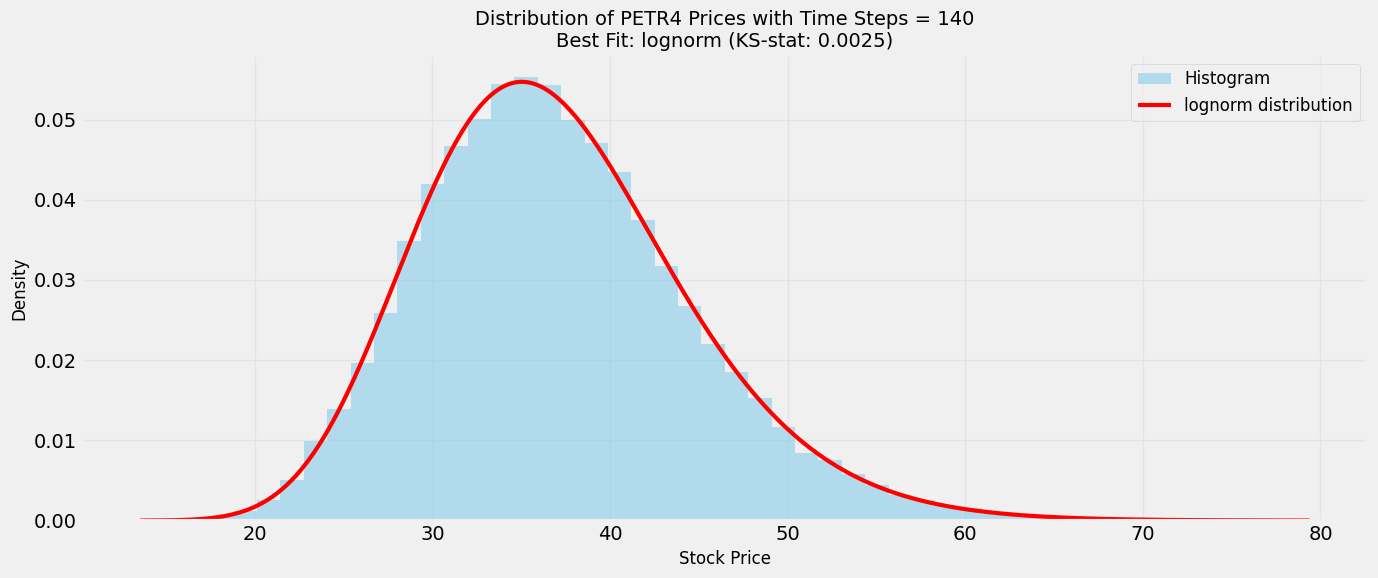


Generating visualization for time_steps = 230...


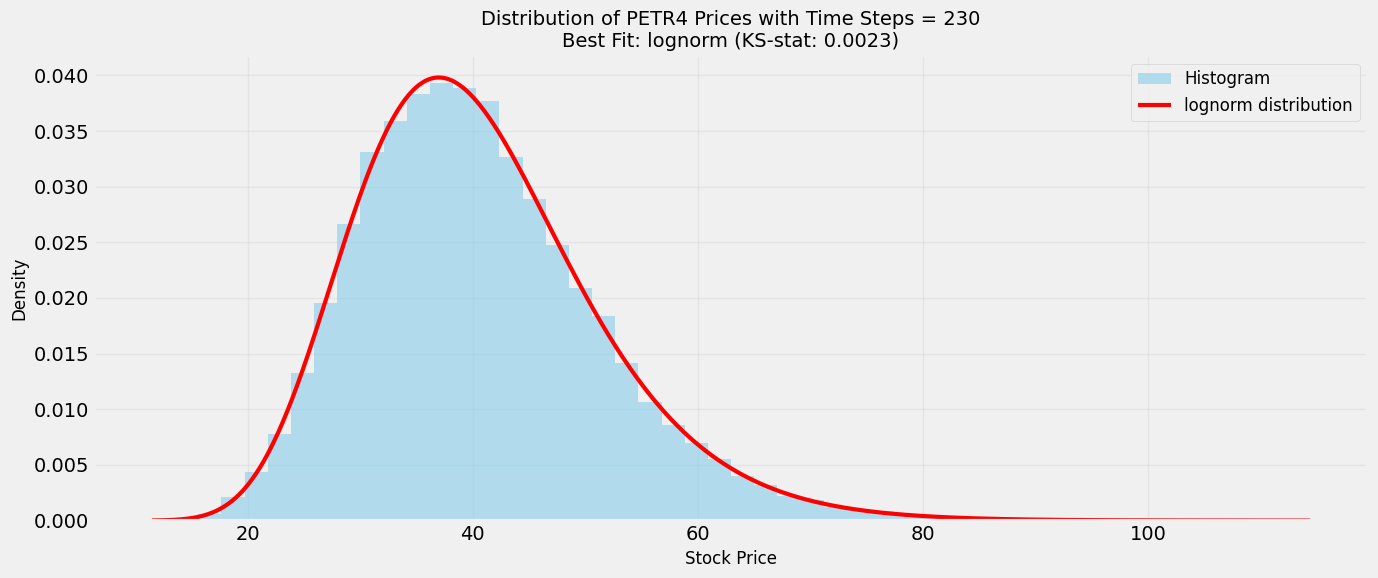


Generating visualization for time_steps = 235...


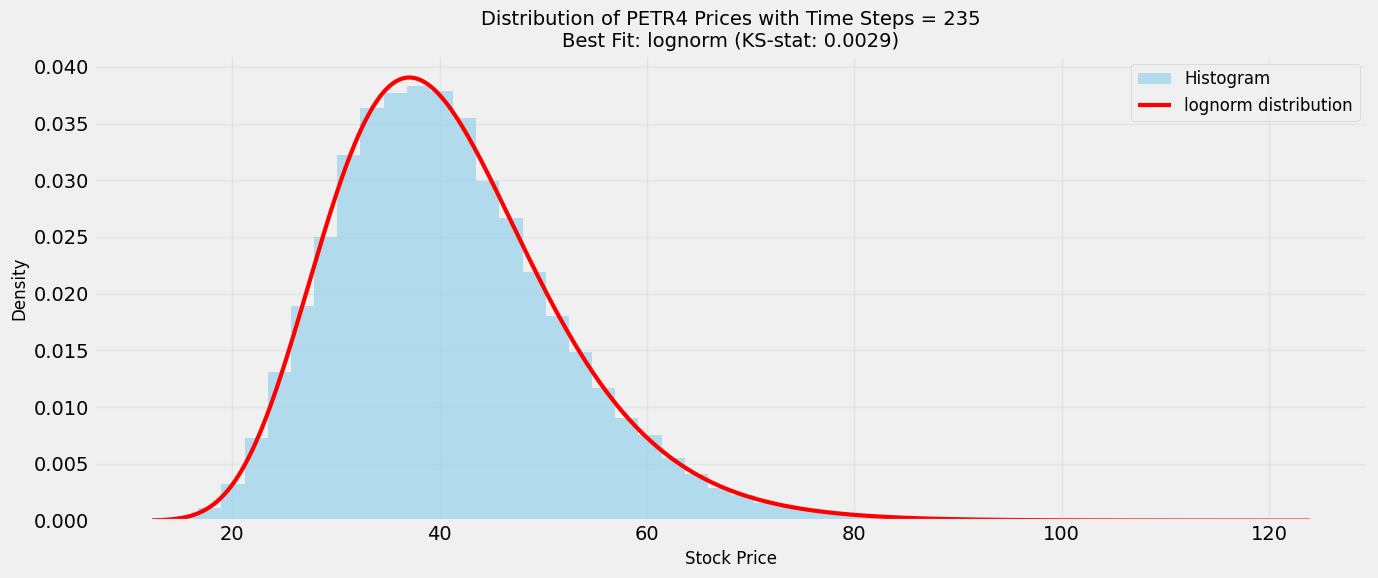


Generating visualization for time_steps = 235...


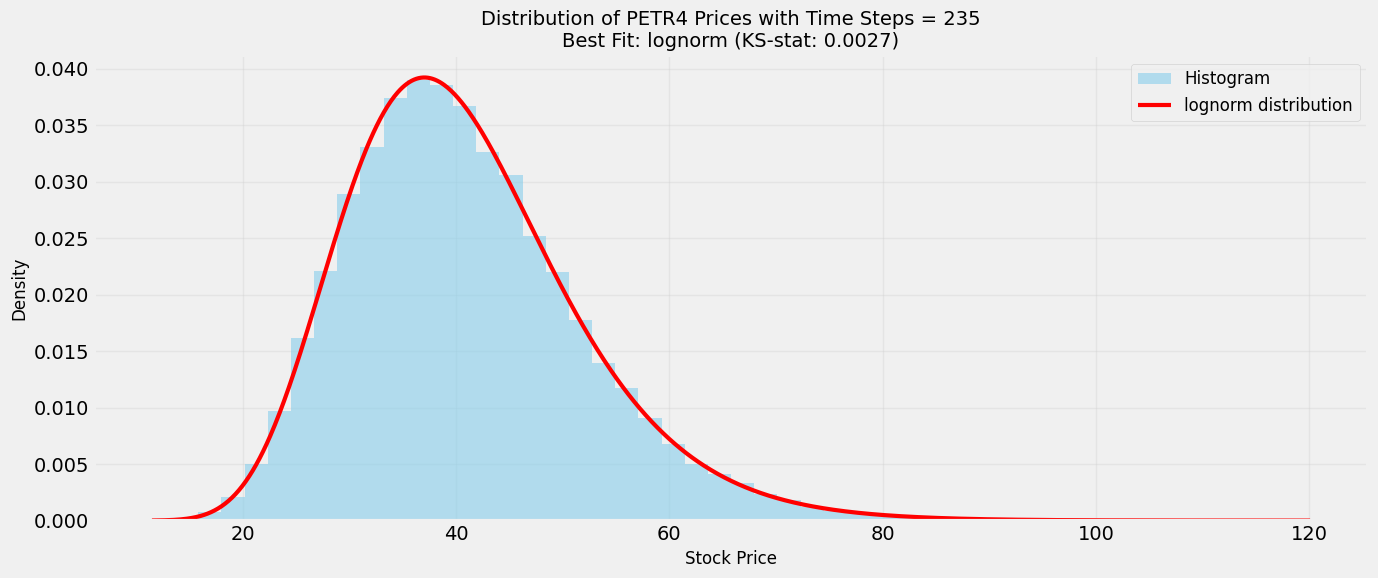


Generating visualization for time_steps = 240...


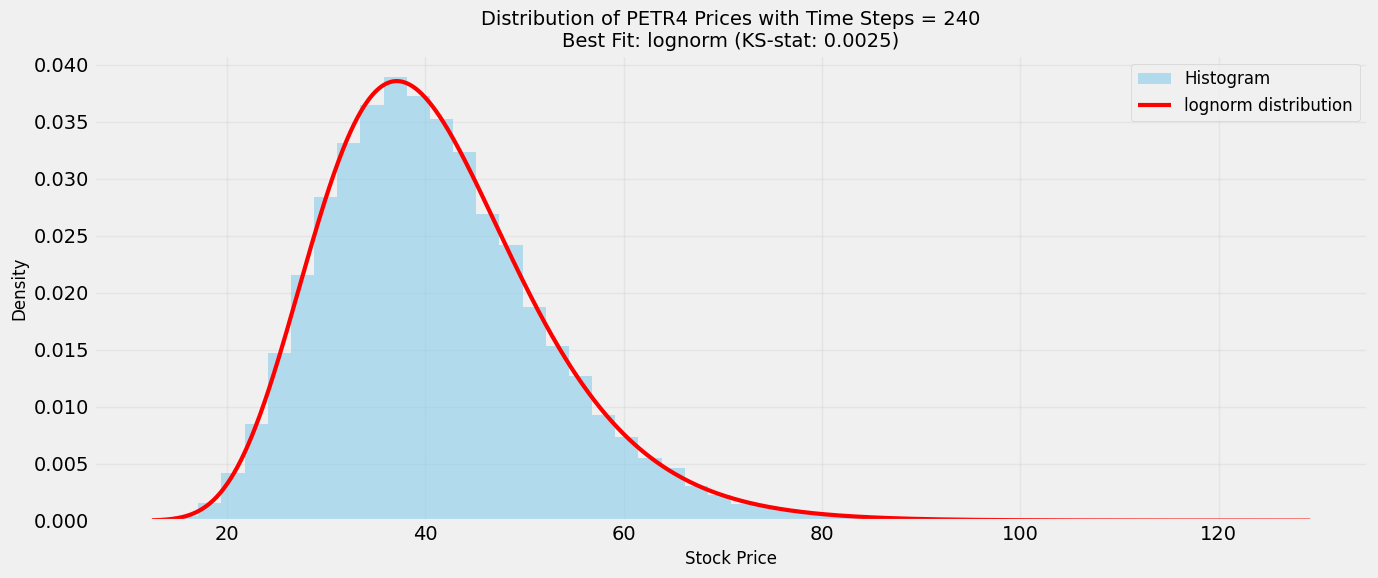

In [33]:
# Experiment: Find the transition point where the best-fitting distribution changes
# with increasing time steps

import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import time
import warnings

# Suppress warnings to keep output clean
warnings.filterwarnings('ignore')

# Define distributions to test
distributions = [
    st.norm, st.lognorm, st.gamma, st.weibull_min, st.t, st.beta,
    st.expon, st.chi2, st.rayleigh, st.logistic
]

# Set fixed parameters
ticker = "PETR4"
period = 24  # months
iterations = 50000  # number of simulation paths
start_time_steps = 5
max_time_steps = 260  # Approximately one trading year
step_size = 5

# Initialize results storage
results_df = pd.DataFrame(columns=['time_steps', 'best_dist', 'ks_stat', 'p_value', 
                                   'second_best', 'second_ks', 'third_best', 'third_ks'])

print(f"Running simulations for {ticker} with varying time steps...")
print(f"This may take some time to complete.")

# Loop through different time steps
for time_steps in range(start_time_steps, max_time_steps + 1, step_size):
    print(f"\nRunning simulation with time_steps = {time_steps}...")
    start = time.time()
    
    # Run bootstrap simulation with current time_steps
    sim_results = run_bootstrap(ticker, period, iterations, time_steps)
    
    # Get arrival values
    arrival_values = np.array(sim_results[ticker]['monte_carlo']['all_arrivals'])
    
    # Find best distribution
    best_fits = find_best_distribution(arrival_values, distributions)
    
    # Extract top 3 results
    best_dist_name, best_dist_data = best_fits[0]
    second_dist_name, second_dist_data = best_fits[1]
    third_dist_name, third_dist_data = best_fits[2]
    
    # Store results
    results_df = pd.concat([results_df, pd.DataFrame({
        'time_steps': [time_steps],
        'best_dist': [best_dist_name],
        'ks_stat': [best_dist_data['D']],
        'p_value': [best_dist_data['p_value']],
        'second_best': [second_dist_name],
        'second_ks': [second_dist_data['D']],
        'third_best': [third_dist_name],
        'third_ks': [third_dist_data['D']]
    })])
    
    end = time.time()
    print(f"Best fit: {best_dist_name}, KS statistic: {best_dist_data['D']:.4f}")
    print(f"Second best: {second_dist_name}, KS statistic: {second_dist_data['D']:.4f}")
    print(f"Elapsed time: {end - start:.2f} seconds")

# Display final results
print("\nFinal Results:")
print(results_df)

# Identify transition point
transition_indices = []
for i in range(1, len(results_df)):
    if results_df.iloc[i]['best_dist'] != results_df.iloc[i-1]['best_dist']:
        transition_indices.append(i)

if transition_indices:
    print("\nTransition points detected at:")
    for idx in transition_indices:
        from_dist = results_df.iloc[idx-1]['best_dist']
        to_dist = results_df.iloc[idx]['best_dist']
        ts = results_df.iloc[idx]['time_steps']
        print(f"Time steps = {ts}: Changed from {from_dist} to {to_dist}")
else:
    print("\nNo transition points detected")

# Plot the results
plt.figure(figsize=(14, 8))

# Plot KS statistics for top 3 distributions
for dist in ['best_dist', 'second_best', 'third_best']:
    dist_groups = results_df.groupby(dist)
    for name, group in dist_groups:
        marker = 'o' if dist == 'best_dist' else ('s' if dist == 'second_best' else '^')
        size = 100 if dist == 'best_dist' else (60 if dist == 'second_best' else 40)
        alpha = 1.0 if dist == 'best_dist' else (0.7 if dist == 'second_best' else 0.5)
        
        if dist == 'best_dist':
            plt.scatter(group['time_steps'], group['ks_stat'], 
                        label=f"{name} (best)", marker=marker, s=size, alpha=alpha)
        else:
            ks_col = 'second_ks' if dist == 'second_best' else 'third_ks'
            plt.scatter(group['time_steps'], group[ks_col], 
                        label=f"{name} ({dist.split('_')[0]})", marker=marker, s=size, alpha=alpha)

# Add transition point markers if any
for idx in transition_indices:
    ts = results_df.iloc[idx]['time_steps']
    ks = results_df.iloc[idx]['ks_stat']
    plt.axvline(x=ts, color='red', linestyle='--', alpha=0.5)
    plt.text(ts + 2, min(results_df['ks_stat']) * 1.1, 
             f"Transition\npoint", color='red', fontweight='bold')

plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Kolmogorov-Smirnov Statistic', fontsize=12)
plt.title(f'Distribution Fit Quality vs Time Steps for {ticker}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

# Plot the histogram and best distribution for key time steps points
if transition_indices:
    # Plot distribution for time steps before and after transition
    for idx in transition_indices:
        before_ts = results_df.iloc[idx-1]['time_steps']
        after_ts = results_df.iloc[idx]['time_steps']
        
        # Plot data for selected time steps
        for ts in [before_ts, after_ts]:
            # Re-run simulation for specific time step
            print(f"\nGenerating visualization for time_steps = {ts}...")
            sim_results = run_bootstrap(ticker, period, iterations, ts)
            arrival_values = np.array(sim_results[ticker]['monte_carlo']['all_arrivals'])
            
            # Find best distribution
            best_fits = find_best_distribution(arrival_values, distributions)
            best_dist_name, best_dist_data = best_fits[0]
            best_dist = best_dist_data['distribution']
            best_params = best_dist_data['params']
            
            # Plot histogram with fitted distribution
            plt.figure(figsize=(14, 6))
            
            # Plot histogram
            hist_data = plt.hist(arrival_values, bins=50, density=True, alpha=0.6, 
                                color='skyblue', label='Histogram')
            
            # Generate points for distribution curve
            x = np.linspace(arrival_values.min(), arrival_values.max(), 1000)
            pdf = best_dist.pdf(x, *best_params)
            
            # Plot fitted distribution
            plt.plot(x, pdf, 'r-', linewidth=3, label=f'{best_dist_name} distribution')
            
            # Add title and labels
            plt.title(f'Distribution of {ticker} Prices with Time Steps = {ts}\n'
                     f'Best Fit: {best_dist_name} (KS-stat: {best_dist_data["D"]:.4f})', fontsize=14)
            plt.xlabel('Stock Price', fontsize=12)
            plt.ylabel('Density', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.legend(fontsize=12)
            plt.tight_layout()
            plt.show()